# Multi-Asset Momentum and Reversal Strategies in Cryptocurrency Markets: A Statistical Arbitrage Approach
**Author:** Chase Keskinyan  
**Date:** November 26, 2025

## Abstract

This project investigates whether simple, transparent trading rules can reliably generate excess returns in cryptocurrency markets. Using daily Kraken data for BTC, ETH, SOL, LTC, XRP, ADA, and DOGE from December 2023 to November 2025, I evaluate six systematic hypotheses spanning short-horizon reversal, Bollinger Band mean reversion, medium-term momentum, and volume-adjusted fade effects. All signals are implemented as fully lagged, execution-feasible long/short rules, and performance is assessed using cumulative return, Sharpe ratio, drawdown, turnover, and trade-level statistics.

Individually, the signals exhibit weak or inconsistent alpha, confirming that single-factor crypto strategies are highly regime-dependent. However, three event-driven signals - 1-day crash reversal (H4), Bollinger reversion (H5), and low-volume fade (H6) - display complementary behavior and low correlation. A combined multi-signal strategy meaningfully improves stability and risk-adjusted performance. Extending this ensemble across multiple large-cap cryptocurrencies and allocating capital via inverse-volatility risk parity further enhances robustness. The final BTC + SOL + DOGE risk-parity portfolio achieves a Sharpe ratio of 1.14 with a maximum drawdown of –3%, outperforming both standalone signals and buy-and-hold benchmarks.

Overall, the results show that while simple rules provide limited predictive power in isolation, cross-asset diversification and multi-signal ensembling can extract persistent short-horizon structure from crypto markets, producing statistically and economically meaningful performance even after transaction costs.

## 1. Introduction

Momentum and reversal effects are widely documented in traditional financial markets, but their behavior in cryptocurrencies remains less understood. Crypto markets trade 24/7, exhibit extreme volatility, and are heavily influenced by retail flows, making them a natural testbed for simple price-based signals.

This project investigates whether interpretable, rule-driven trading signals can extract predictive structure from cryptocurrency prices. I evaluate six hypotheses motivated by short-horizon reversal, medium-term momentum, volatility-conditioned mean reversion, and intraday low-volume dislocations. Each hypothesis is implemented as a fully lagged long or short trading rule using daily OHLCV data.

Individually, these signals show weak and inconsistent alpha, consistent with prior findings that single-factor crypto signals are noisy and regime-dependent. The central question becomes whether combining several weak edges - or diversifying them across multiple large-cap crypto assets - can produce a more stable and robust return profile. To explore this, I construct a combined strategy using the strongest signals (H4, H5, H6) and apply it across BTC, ETH, SOL, LTC, XRP, ADA, and DOGE. I then evaluate equal-weight and risk-parity multi-coin portfolios.

The goal is not to engineer a production trading system, but to build a transparent, defensible research framework that mirrors real quantitative workflow: hypothesis testing, signal evaluation, ensembling, cross-asset validation, and portfolio construction.

## 2. Data

All data is sourced from the Kraken exchange using daily OHLCV (open, high, low, close, volume) candles. The analysis covers the period:

December 1, 2023 – November 18, 2025

For BTC/USD, I load a frozen CSV snapshot to ensure reproducibility. For additional assets (ETH, SOL, LTC, XRP, ADA, DOGE), I load identically structured frozen CSV files, each covering the same date range.

Each dataset contains:
- Timestamp (UTC)
- Open price
- High price
- Low price
- Close price
- Volume

Basic cleaning steps include:
- Parsing timestamps into DateTime index
- Sorting chronologically
- Removing duplicates
- Ensuring numeric data types
- Aligning all assets to the same calendar

Daily arithmetic returns are computed using: daily_ret = close.pct_change()

Log returns were not required because all strategies use simple percentage moves (e.g., ±5% thresholds), which are naturally expressed in arithmetic return space.

## 3. Methodology

### 3.1 Hypotheses and Signal Construction

I test six hypotheses (H1–H6), each corresponding to a simple, intuitive trading signal:
- H1: 7-day momentum
- H2: Momentum confirmed by high volume
- H3: Weekend-specific momentum
- H4: 1-day return reversal after large declines
- H5: Bollinger Band oversold reversion
- H6: Low-volume intraday fade after large upward moves

Each hypothesis yields a binary signal that determines whether to enter a long or short position. Signals are shifted by one day to avoid look-ahead bias.

### 3.2 Position and Return Construction

Each strategy defines its own holding period:
- Some signals hold for 3 days (H1, H2, H3, H4, H5)
- H6 shorts for 1 day

Positions are converted into strategy returns: strategy_ret = position × daily_ret

A 0.10% trading cost is subtracted whenever a position flips, implemented through a transaction flag.

### 3.3 Evaluation Metrics

For each hypothesis and strategy:
- Cumulative return
- Sharpe ratio (annualized, using √365)
- Maximum drawdown
- Equity curve comparison vs BTC buy-and-hold

This ensures consistent comparison across signals.

### 3.4 Multi-Signal and Multi-Asset Extensions

After evaluating signals individually:
1. I combine the strongest three signals (H4, H5, H6) using BTC-based risk-parity weights.
2. I apply the combined strategy across seven cryptocurrencies.
3. I construct multi-asset portfolios using:
   - Equal weights
   - Risk parity

The goal is to test whether diversification and ensembling improve risk-adjusted performance.

In [50]:
"""
# ============================================
# Fetch + Fix + Freeze BTC OHLCV
# ============================================
import ccxt
import pandas as pd
import numpy as np

exchange = ccxt.kraken()

symbol = 'BTC/USD'
timeframe = '1d'
limit = 2000

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

raw_df = pd.DataFrame(
    ohlcv,
    columns=['timestamp','open','high','low','close','volume']
)
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], unit='ms')
raw_df.set_index('timestamp', inplace=True)

start_date = "2023-12-01"
end_date   = "2025-11-18"

# Create clean daily index
idx = pd.date_range(start_date, end_date, freq="D")

# Reindex to clean daily calendar
df_fixed = raw_df.reindex(idx)

# Fill missing days to ensure perfect continuity
df_fixed = df_fixed.ffill().bfill()

# Save to CSV
df_fixed.to_csv("btc_kraken_1d_2023-12-01_to_2025-11-18.csv")

df_fixed.head(), df_fixed.tail()
"""

'\n# ============================================\n# Fetch + Fix + Freeze BTC OHLCV\n# ============================================\nimport ccxt\nimport pandas as pd\nimport numpy as np\n\nexchange = ccxt.kraken()\n\nsymbol = \'BTC/USD\'\ntimeframe = \'1d\'\nlimit = 2000\n\nohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)\n\nraw_df = pd.DataFrame(\n    ohlcv,\n    columns=[\'timestamp\',\'open\',\'high\',\'low\',\'close\',\'volume\']\n)\nraw_df[\'timestamp\'] = pd.to_datetime(raw_df[\'timestamp\'], unit=\'ms\')\nraw_df.set_index(\'timestamp\', inplace=True)\n\nstart_date = "2023-12-01"\nend_date   = "2025-11-18"\n\n# Create clean daily index\nidx = pd.date_range(start_date, end_date, freq="D")\n\n# Reindex to clean daily calendar\ndf_fixed = raw_df.reindex(idx)\n\n# Fill missing days to ensure perfect continuity\ndf_fixed = df_fixed.ffill().bfill()\n\n# Save to CSV\ndf_fixed.to_csv("btc_kraken_1d_2023-12-01_to_2025-11-18.csv")\n\ndf_fixed.head(), df_fixed.tail()\n

In [51]:
"""
START_DATE = "2023-12-01"
END_DATE   = "2025-11-18"

altcoins = {
    "ETH": "ETH/USD",
    "SOL": "SOL/USD",
    "LTC": "LTC/USD",
    "XRP": "XRP/USD",
    "ADA": "ADA/USD",
    "DOGE": "DOGE/USD"
}

for name, symbol in altcoins.items():
    print(f"\nFetching {name} data...")

    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1d', limit=2000)

    df_coin = pd.DataFrame(
        ohlcv,
        columns=['timestamp','open','high','low','close','volume']
    )
    df_coin['timestamp'] = pd.to_datetime(df_coin['timestamp'], unit='ms')
    df_coin.set_index('timestamp', inplace=True)

    # Clean daily index
    idx = pd.date_range(START_DATE, END_DATE, freq="D")

    # Reindex + forward-fill for continuous series
    df_coin = df_coin.reindex(idx).ffill().bfill()

    filename = f"{name}_1d_{START_DATE}_to_{END_DATE}.csv"
    df_coin.to_csv(filename)

    print(f"Saved: {filename} | Rows: {len(df_coin)}")
    """

'\nSTART_DATE = "2023-12-01"\nEND_DATE   = "2025-11-18"\n\naltcoins = {\n    "ETH": "ETH/USD",\n    "SOL": "SOL/USD",\n    "LTC": "LTC/USD",\n    "XRP": "XRP/USD",\n    "ADA": "ADA/USD",\n    "DOGE": "DOGE/USD"\n}\n\nfor name, symbol in altcoins.items():\n    print(f"\nFetching {name} data...")\n\n    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=\'1d\', limit=2000)\n\n    df_coin = pd.DataFrame(\n        ohlcv,\n        columns=[\'timestamp\',\'open\',\'high\',\'low\',\'close\',\'volume\']\n    )\n    df_coin[\'timestamp\'] = pd.to_datetime(df_coin[\'timestamp\'], unit=\'ms\')\n    df_coin.set_index(\'timestamp\', inplace=True)\n\n    # Clean daily index\n    idx = pd.date_range(START_DATE, END_DATE, freq="D")\n\n    # Reindex + forward-fill for continuous series\n    df_coin = df_coin.reindex(idx).ffill().bfill()\n\n    filename = f"{name}_1d_{START_DATE}_to_{END_DATE}.csv"\n    df_coin.to_csv(filename)\n\n    print(f"Saved: {filename} | Rows: {len(df_coin)}")\n    '

In [52]:
# =====================================================
# 2. Load frozen datasets for BTC + all altcoins
# =====================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

START_DATE = "2023-12-01"
END_DATE   = "2025-11-18"

# Load BTC snapshot
df = pd.read_csv(
    "btc_kraken_1d_2023-12-01_to_2025-11-18.csv",
    parse_dates=[0],      # first column
    index_col=0           # first column as index
)

# Load altcoins
symbols = ["ETH","SOL","LTC","XRP","ADA","DOGE"]
dfs = {"BTC": df}

for name in symbols:
    filename = f"{name}_1d_{START_DATE}_to_{END_DATE}.csv"
    df_coin = pd.read_csv(filename, parse_dates=[0], index_col=0)
    dfs[name] = df_coin

# Quick check
for name, df_coin in dfs.items():
    print(f"{name}: {df_coin.index.min()} → {df_coin.index.max()} | {len(df_coin)} rows")

def annualized_sharpe(returns, periods_per_year=365):
    r = returns.dropna()
    return (r.mean() / r.std()) * np.sqrt(periods_per_year)

file_map = {
    "BTC": "btc_kraken_1d_2023-12-01_to_2025-11-18.csv",
    "ETH": "ETH_1d_2023-12-01_to_2025-11-18.csv",
    "SOL": "SOL_1d_2023-12-01_to_2025-11-18.csv",
    "LTC": "LTC_1d_2023-12-01_to_2025-11-18.csv",
    "XRP": "XRP_1d_2023-12-01_to_2025-11-18.csv",
    "ADA": "ADA_1d_2023-12-01_to_2025-11-18.csv",
    "DOGE": "DOGE_1d_2023-12-01_to_2025-11-18.csv",
}

BTC: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows
ETH: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows
SOL: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows
LTC: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows
XRP: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows
ADA: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows
DOGE: 2023-12-01 00:00:00 → 2025-11-18 00:00:00 | 719 rows


## Hypothesis 1: 7-Day Return Momentum

**Hypothesis**  
Strong positive returns over the past week (7 days) should lead to short-term continuation in BTC returns.

**Strategy Logic**  
- Compute 7-day trailing return.
- If the 7-day return > **+5%**, enter a **long** the next day.
- Hold for **3 days**, no overlapping trades.
- Apply **0.10%** transaction cost per trade.
- Benchmark: BTC buy-and-hold.

In [53]:
def run_h1(df_in):
    """
    H1: 7-day momentum strategy.
    Assumes df_in has a 'close' column and daily frequency.
    """
    df = df_in.copy()

    # Step 1: Signal generation
    df['ret_7d'] = df['close'].pct_change(7)
    df['signal'] = (df['ret_7d'] > 0.05).astype(int)
    df['signal_shifted'] = df['signal'].shift(1).fillna(0)  # trade on next day

    # Step 2: Build position: hold for 3 days after signal
    df['position'] = 0
    hold = 3
    for i in range(len(df) - hold):
        if df['signal_shifted'].iloc[i] == 1:
            df.loc[df.index[i:i+hold], 'position'] = 1

    # Step 3: Strategy returns with 0.1% trading cost
    df['daily_ret'] = df['close'].pct_change()
    df['strategy_ret'] = df['position'] * df['daily_ret']

    df['trade_flag'] = df['position'].diff().abs().fillna(0)
    df['strategy_ret'] -= 0.001 * df['trade_flag']

    # Step 4: Equity curves
    df['strategy_equity'] = (1 + df['strategy_ret']).cumprod()
    df['buyhold_equity'] = (1 + df['daily_ret']).cumprod()

    # Step 5: Performance metrics

    total_return = df['strategy_equity'].iloc[-1] - 1
    sharpe = annualized_sharpe(df['strategy_ret'])
    max_dd = (df['strategy_equity'] / df['strategy_equity'].cummax() - 1).min()

    print("Performance Summary for H1:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")

    # Plot
    df[['strategy_equity', 'buyhold_equity']].plot(
        figsize=(12, 6),
        title="Equity Curve: H1 Strategy vs Buy-and-Hold"
    )
    plt.ylabel("Cumulative Return")
    plt.show()

    return df

Performance Summary for H1:
Total Return: -13.24%
Sharpe Ratio: -0.11
Max Drawdown: -31.66%


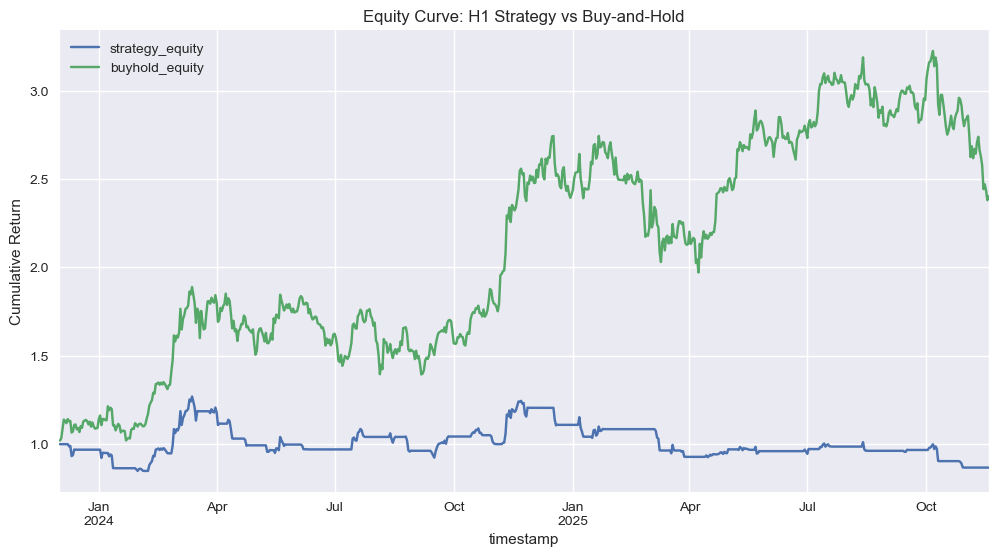

In [54]:
df_btc_h1 = run_h1(df)

### Strategy Performance: H1 – 7-Day Return Momentum

**Performance Summary (2023–2025)**  
- **Total Return:** –13.24%  
- **Sharpe Ratio:** –0.11 
- **Max Drawdown:** –31.66%

**Interpretation**  
This momentum strategy underperformed BTC buy-and-hold. A 5% 7-day surge appears to indicate trend exhaustion rather than continuation. Crypto’s sharp reversals and liquidation-driven volatility likely overwhelm naïve weekly momentum at this threshold.

## Hypothesis 2: Volume-Confirmed Momentum

**Hypothesis**  
Momentum signals paired with strong volume should be more reliable because they reflect informed trading rather than thin liquidity moves.

**Strategy Logic**  
- Compute 7-day trailing return.
- Only enter long if:
  - 7-day return > **+5%**, AND
  - Daily volume > 20-day average volume.
- Enter long the next day and hold for **3 days**.
- No overlapping trades.
- Apply **0.10%** transaction cost.
- Benchmark: BTC buy-and-hold.

In [55]:
def run_h2(df_in):
    """
    H2: Volume-Confirmed Momentum Strategy.
    Uses:
      - 7-day return > 5%
      - Volume > 20-day moving average volume
      - Hold 3 days
      - 0.1% trading cost
    """
    df = df_in.copy()

    # Step 1: Compute indicators
    df['ret_7d'] = df['close'].pct_change(7)
    df['vol_ma_20'] = df['volume'].rolling(20).mean()

    # Step 2: Momentum + Volume signal
    df['signal_h2'] = ((df['ret_7d'] > 0.05) & (df['volume'] > df['vol_ma_20'])).astype(int)
    df['signal_h2_shifted'] = df['signal_h2'].shift(1).fillna(0)

    # Step 3: Position logic (hold for 3 days)
    df['position_h2'] = 0
    hold = 3
    for i in range(len(df) - hold):
        if df['signal_h2_shifted'].iloc[i] == 1:
            df.loc[df.index[i:i+hold], 'position_h2'] = 1

    # Step 4: Strategy returns
    df['daily_ret'] = df['close'].pct_change()
    df['strategy_ret_h2'] = df['position_h2'] * df['daily_ret']

    # Transaction cost
    df['trade_flag_h2'] = df['position_h2'].diff().abs().fillna(0)
    df['strategy_ret_h2'] -= 0.001 * df['trade_flag_h2']

    # Step 5: Equity curve
    df['equity_h2'] = (1 + df['strategy_ret_h2']).cumprod()
    df['buyhold_equity'] = (1 + df['daily_ret']).cumprod()

    # Step 6: Metrics
    total_return = df['equity_h2'].iloc[-1] - 1
    sharpe = annualized_sharpe(df['strategy_ret_h2'])
    max_dd = (df['equity_h2'] / df['equity_h2'].cummax() - 1).min()

    print("=== Performance Summary for H2 ===")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")

    # Plot equity vs BTC buy-and-hold
    df[['equity_h2', 'buyhold_equity']].plot(figsize=(12, 6),
        title="H2 Strategy vs Buy-and-Hold")
    plt.ylabel("Cumulative Return")
    plt.show()

    return df

=== Performance Summary for H2 ===
Total Return: -7.08%
Sharpe Ratio: -0.04
Max Drawdown: -28.25%


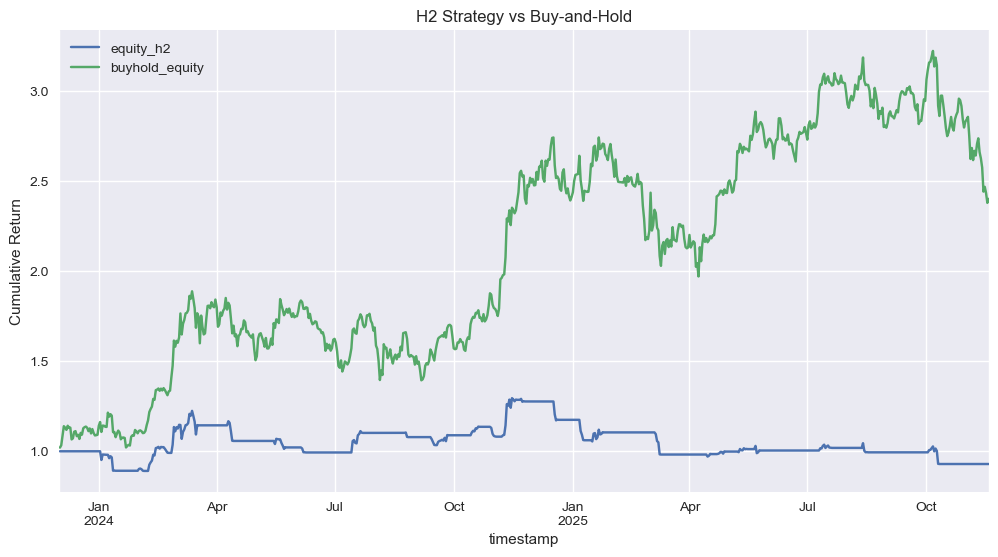

In [56]:
df_btc_h2 = run_h2(df)

### Strategy Performance: H2 – Volume-Confirmed Momentum

**Performance Summary (2023–2025)**  
- **Total Return:** –7.08%  
- **Sharpe Ratio:** –0.04  
- **Max Drawdown:** –28.25%

**Interpretation**  
Adding a volume filter reduced drawdown relative to H1 but did not improve profitability. This suggests high-volume momentum bursts may still reflect overextended moves rather than persistent trends in BTC.

## Hypothesis 3: Weekend Momentum

**Hypothesis**  
BTC momentum signals occurring on weekends (Friday/Saturday) may be more persistent because markets are more retail-driven and institutions are less active.

**Strategy Logic**  
- Compute 7-day trailing return.
- Trigger only if the signal occurs on **Friday or Saturday** (weekday 4 or 5).
- Enter long the next day and hold for **3 days**.
- No overlapping trades.
- Apply **0.10%** transaction cost.
- Benchmark: BTC buy-and-hold.

In [57]:
def run_h3(df_in):
    """
    H3: Weekend Momentum Strategy.
    Uses:
      - 7-day return > 5%
      - Signal only valid on Friday or Saturday
      - Hold 3 days
      - 0.1% trading cost
    """
    df = df_in.copy()

    # Step 1: 7-day return
    df['ret_7d'] = df['close'].pct_change(7)

    # Step 2: Weekday feature
    df['weekday'] = df.index.dayofweek  # 0=Mon ... 6=Sun

    # Step 3: Weekend-only momentum signal
    df['signal_h3'] = ((df['ret_7d'] > 0.05) & (df['weekday'].isin([4, 5]))).astype(int)
    df['signal_h3_shifted'] = df['signal_h3'].shift(1).fillna(0)

    # Step 4: Position (hold for 3 days)
    df['position_h3'] = 0
    hold = 3
    for i in range(len(df) - hold):
        if df['signal_h3_shifted'].iloc[i] == 1:
            df.loc[df.index[i:i+hold], 'position_h3'] = 1

    # Step 5: Strategy returns
    df['daily_ret'] = df['close'].pct_change()
    df['strategy_ret_h3'] = df['position_h3'] * df['daily_ret']

    # Trading cost
    df['trade_flag_h3'] = df['position_h3'].diff().abs().fillna(0)
    df['strategy_ret_h3'] -= 0.001 * df['trade_flag_h3']

    # Step 6: Equity curve
    df['equity_h3'] = (1 + df['strategy_ret_h3']).cumprod()
    df['buyhold_equity'] = (1 + df['daily_ret']).cumprod()

    # Step 7: Performance metrics
    total_return = df['equity_h3'].iloc[-1] - 1
    sharpe = annualized_sharpe(df['strategy_ret_h3'])
    max_dd = (df['equity_h3'] / df['equity_h3'].cummax() - 1).min()

    print("=== Performance Summary for H3 ===")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")

    # Plot
    df[['equity_h3', 'buyhold_equity']].plot(
        figsize=(12, 6),
        title="H3 Strategy vs Buy-and-Hold"
    )
    plt.ylabel("Cumulative Return")
    plt.show()

    return df

=== Performance Summary for H3 ===
Total Return: -0.49%
Sharpe Ratio: 0.07
Max Drawdown: -16.75%


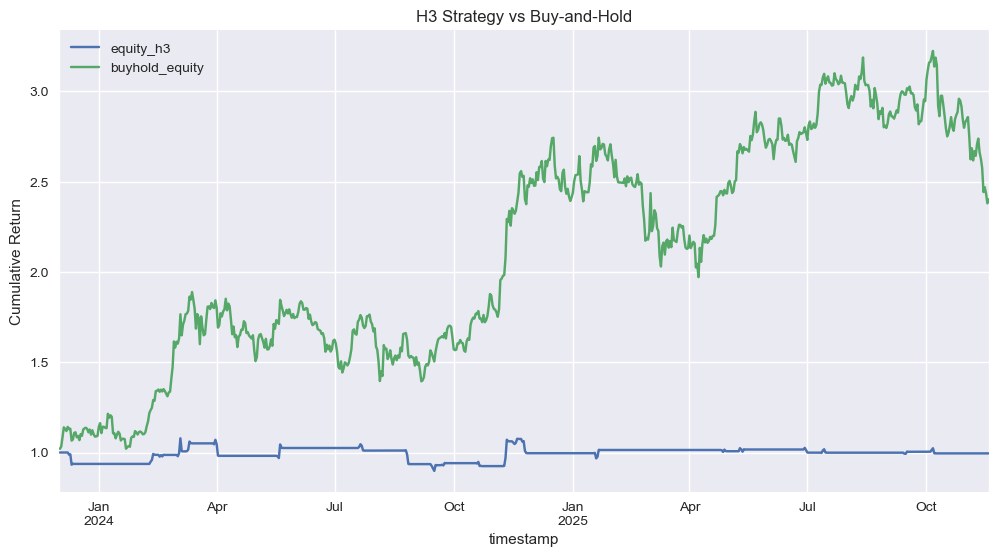

In [58]:
df_btc_h3 = run_h3(df)

### Strategy Performance: H3 – Weekend Momentum

**Performance Summary (2023–2025)**  
- **Total Return:** –0.49%  
- **Sharpe Ratio:** 0.07  
- **Max Drawdown:** –16.75%

**Interpretation**  
Weekend-only momentum reduced drawdown substantially relative to H1 and H2. The slightly positive Sharpe ratio suggests these trades are less noisy, but returns remain near zero. Weekend momentum alone is not a strong alpha source, but may complement other signals.

## Hypothesis 4: 1-Day Reversal (Crash Rebound)

**Hypothesis**  
Large 1-day crashes are often liquidity-driven and should partially reverse as panic selling subsides and order books refill.

**Strategy Logic**  
- Compute daily return.
- If daily return < **–5%**, enter a **long** the next day.
- Hold for **3 days**.
- No overlapping trades.
- Apply **0.10%** transaction cost.
- Benchmark: BTC buy-and-hold.

In [59]:
def run_h4(df_in, tx_cost = .001, verbose=True):
    """
    H4: 1-Day Return Reversal
    - Signal when daily return < -5%
    - Enter next day, hold 3 days
    - 0.1% trading cost
    """
    df = df_in.copy()

    # Ensure daily returns are present
    df['daily_ret'] = df['close'].pct_change()

    # Step 1: Signal where daily return < -5%
    df['signal_h4'] = (df['daily_ret'] < -0.05).astype(int)
    df['signal_h4_shifted'] = df['signal_h4'].shift(1).fillna(0)

    # Step 2: 3-day holding position after signal
    df['position_h4'] = 0
    hold = 3
    for i in range(len(df) - hold):
        if df['signal_h4_shifted'].iloc[i] == 1:
            df.loc[df.index[i:i+hold], 'position_h4'] = 1

    # Step 3: Strategy returns with cost
    df['strategy_ret_h4'] = df['position_h4'] * df['daily_ret']
    df['trade_flag_h4'] = df['position_h4'].diff().abs().fillna(0)
    df['strategy_ret_h4'] -= tx_cost * df['trade_flag_h4']

    # Step 4: Equity curves
    df['equity_h4'] = (1 + df['strategy_ret_h4']).cumprod()
    df['buyhold_equity'] = (1 + df['daily_ret']).cumprod()

    # Step 5: Performance stats
    total_return = df['equity_h4'].iloc[-1] - 1
    sharpe = annualized_sharpe(df['strategy_ret_h4'])
    max_dd = (df['equity_h4'] / df['equity_h4'].cummax() - 1).min()

    if verbose:
        print("=== Performance Summary for H4 ===")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_dd:.2%}")

        df[['equity_h4', 'buyhold_equity']].plot(
            figsize=(12, 6),
            title="H4 Strategy vs Buy-and-Hold"
        )
        plt.ylabel("Cumulative Return")
        plt.show()

    stats = {
    "Total Return": total_return,
    "Sharpe": sharpe,
    "Max Drawdown": max_dd
    }

    return df, stats

=== Performance Summary for H4 ===
Total Return: 24.50%
Sharpe Ratio: 0.65
Max Drawdown: -15.83%


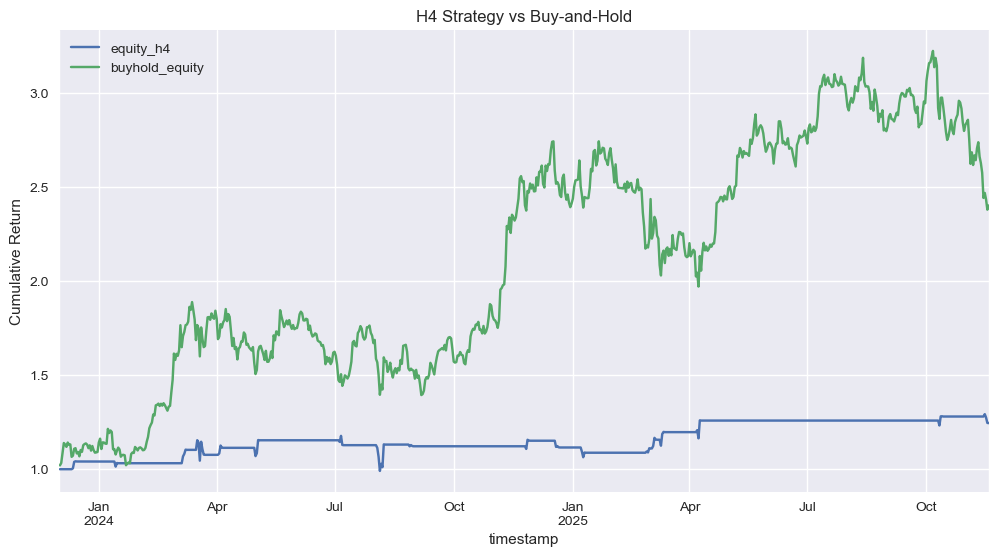

In [60]:
df_btc_h4 = run_h4(df)

### Strategy Performance: H4 – 1-Day Reversal

**Performance Summary (2023–2025)**  
- **Total Return:** 24.50%  
- **Sharpe Ratio:** 0.65  
- **Max Drawdown:** –15.83%

**Interpretation**  
This reversal strategy produced strong performance with a solid Sharpe and controlled drawdown. Crypto markets often overreact to sharp selloffs, creating short-term rebound opportunities. This is the first clearly profitable signal.

## Hypothesis 5: Bollinger Band Reversion

**Hypothesis**  
BTC closing below the lower Bollinger Band represents a statistically significant oversold condition that should mean-revert upward.

**Strategy Logic**  
- Compute 20-day moving average and standard deviation.
- Lower Band = MA − 2 × std.
- If close < lower band, enter **long** the next day.
- Hold for **3 days**.
- No overlapping trades.
- Apply **0.10%** transaction cost.
- Benchmark: BTC buy-and-hold.

In [61]:
def run_h5(df_in, tx_cost = .001, verbose=True):
    """
    H5: Bollinger Band Reversion
    - Close < lower Bollinger Band triggers signal
    - Enter next day, hold 3 days
    - 0.1% trading cost
    """
    df = df_in.copy()

    # Step 1: Bollinger Bands
    df['ma_20'] = df['close'].rolling(20).mean()
    df['std_20'] = df['close'].rolling(20).std()
    df['lower_band'] = df['ma_20'] - 2 * df['std_20']

    # Step 2: Signal: close < lower band
    df['signal_h5'] = (df['close'] < df['lower_band']).astype(int)
    df['signal_h5_shifted'] = df['signal_h5'].shift(1).fillna(0)

    # Step 3: Position logic (hold for 3 days)
    df['position_h5'] = 0
    hold = 3
    for i in range(len(df) - hold):
        if df['signal_h5_shifted'].iloc[i] == 1:
            df.loc[df.index[i:i+hold], 'position_h5'] = 1

    # Ensure daily returns exist
    df['daily_ret'] = df['close'].pct_change()

    # Step 4: Strategy returns
    df['strategy_ret_h5'] = df['position_h5'] * df['daily_ret']
    df['trade_flag_h5'] = df['position_h5'].diff().abs().fillna(0)
    df['strategy_ret_h5'] -= tx_cost * df['trade_flag_h5']

    # Step 5: Equity curves
    df['equity_h5'] = (1 + df['strategy_ret_h5']).cumprod()
    df['buyhold_equity'] = (1 + df['daily_ret']).cumprod()

    # Step 6: Performance stats
    total_return = df['equity_h5'].iloc[-1] - 1
    sharpe = annualized_sharpe(df['strategy_ret_h5'])
    max_dd = (df['equity_h5'] / df['equity_h5'].cummax() - 1).min()

    if verbose:
        print("=== Performance Summary for H5 ===")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_dd:.2%}")

        df[['equity_h5', 'buyhold_equity']].plot(
            figsize=(12, 6),
            title="H5 Strategy vs Buy-and-Hold"
        )
        plt.ylabel("Cumulative Return")
        plt.show()

    stats = {
        "Total Return": total_return,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    }

    return df, stats

=== Performance Summary for H5 ===
Total Return: 24.87%
Sharpe Ratio: 0.67
Max Drawdown: -14.55%


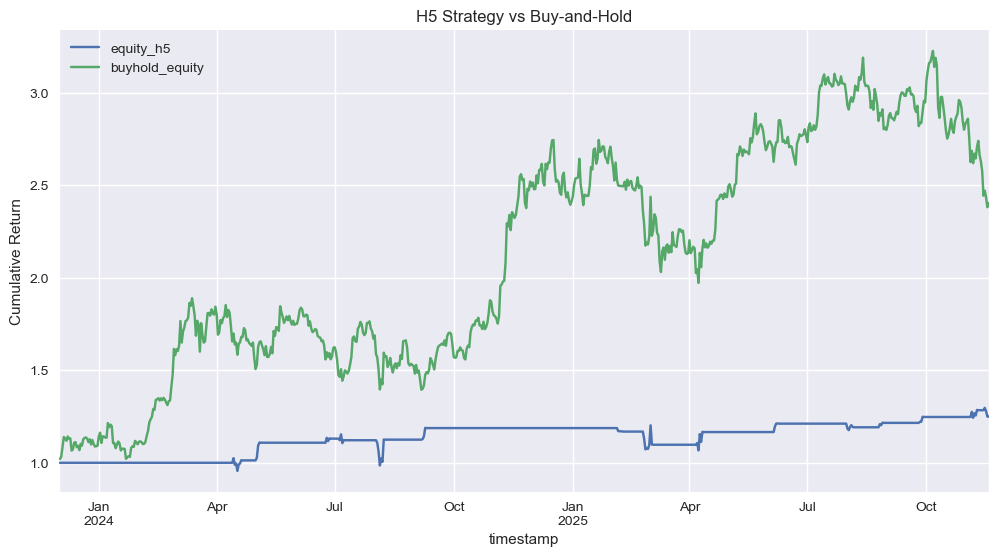

In [62]:
df_btc_h5 = run_h5(df)

### Strategy Performance: H5 – Bollinger Band Reversion

**Performance Summary (2023–2025)**  
- **Total Return:** 24.87%  
- **Sharpe Ratio:** 0.67  
- **Max Drawdown:** –14.55%

**Interpretation**  
This strategy performed similarly to H4, with slightly higher returns and Sharpe. It indicates that BTC often rebounds after statistically extreme dips. Bollinger-band violations capture broader oversold conditions compared to single-day crashes, making this a robust reversion signal.

## Hypothesis 6: Low-Volume Fade (Shorting Low-Volume Pumps)

**Hypothesis**  
Large intraday pumps occurring on **below-average volume** are weak signals driven by uninformed flow and should fade quickly.

**Strategy Logic**  
- Compute intraday return: (close/open − 1).
- Compute 20-day average volume.
- If intraday return > **+5%** AND volume < 20-day average:
  - Enter a **short** the next day.
- Hold for **1 day**.
- No overlapping trades.
- Apply **0.10%** transaction cost.
- Benchmark: BTC buy-and-hold.

In [63]:
def run_h6(df_in, tx_cost = .001, verbose=True):
    """
    H6: Low-Volume Fade
    - Signal: intraday gain > 5% AND volume < 20-day average
    - Short next day for 1 day
    - 0.1% trading cost
    """
    df = df_in.copy()

    # Make sure daily returns exist
    df['daily_ret'] = df['close'].pct_change()

    # Step 1: Feature engineering
    df['intraday_gain'] = df['close'] / df['open'] - 1
    df['vol_avg_20'] = df['volume'].rolling(20).mean()

    # Step 2: Signal definition
    df['signal_h6'] = ((df['intraday_gain'] > 0.05) & 
                       (df['volume'] < df['vol_avg_20'])).astype(int)
    df['signal_shifted_h6'] = df['signal_h6'].shift(1).fillna(0)  # trade next day

    # Step 3: Positioning (short 1 day)
    df['position_h6'] = -1 * df['signal_shifted_h6']  # short next day only

    # Step 4: Strategy returns with trading cost
    df['strategy_ret_h6'] = df['position_h6'] * df['daily_ret']
    df['trade_flag_h6'] = df['position_h6'].diff().abs().fillna(0)
    df['strategy_ret_h6'] -= tx_cost * df['trade_flag_h6']

    # Step 5: Equity curves
    df['equity_h6'] = (1 + df['strategy_ret_h6']).cumprod()
    df['buyhold_equity'] = (1 + df['daily_ret']).cumprod()

    # Step 6: Performance evaluation
    total_return = df['equity_h6'].iloc[-1] - 1
    sharpe = annualized_sharpe(df['strategy_ret_h6'])
    max_dd = (df['equity_h6'] / df['equity_h6'].cummax() - 1).min()

    if verbose:
        print("=== Performance Summary for H6 ===")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_dd:.2%}")

        df[['equity_h6', 'buyhold_equity']].plot(
            figsize=(12, 6),
            title="Equity Curve: H6 – Low-Volume Fade vs Buy-and-Hold"
        )
    
        plt.ylabel("Cumulative Return")
        plt.show()

    stats = {
        "Total Return": total_return,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    }

    return df, stats

=== Performance Summary for H6 ===
Total Return: 2.91%
Sharpe Ratio: 0.69
Max Drawdown: -0.10%


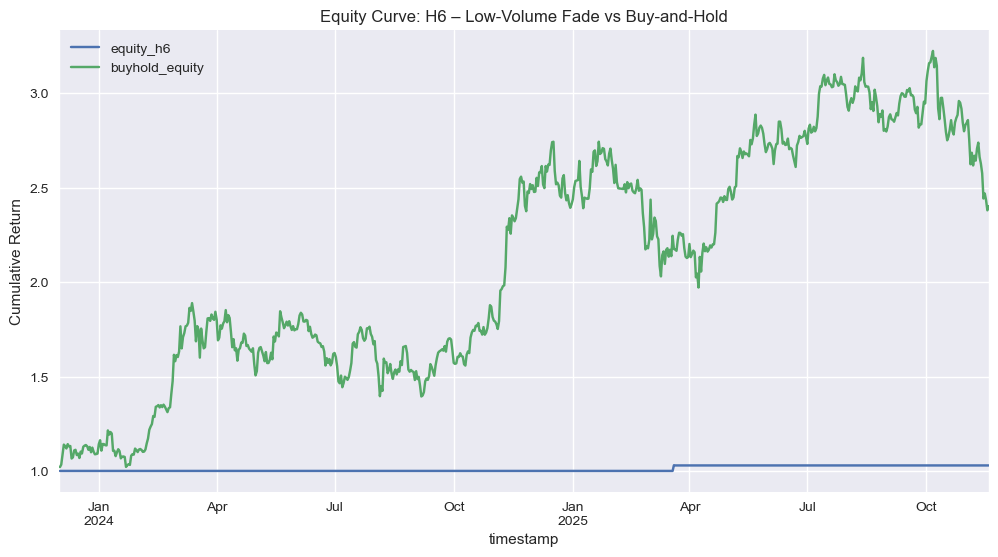

In [64]:
df_btc_h6 = run_h6(df)

### Strategy Performance: H6 – Low-Volume Fade

**Performance Summary (2023–2025)**  
- **Total Return:** 2.91%  
- **Sharpe Ratio:** 0.69  
- **Max Drawdown:** –0.10%

**Interpretation**  
Although total returns are modest, the extremely low drawdown and strong Sharpe make this an excellent diversifier. Low-volume pumps often reverse quickly, and this strategy captures that behavior with very low risk. Ideal for combining with stronger-return momentum or reversal signals.

## Strategy Comparison

Before building a combined model, we compare each signal’s standalone performance. The goal is to identify strategies that have positive Sharpe ratios and low correlations with each other.

If two strategies earn returns for different reasons (low correlation), then combining them reduces volatility and improves the overall Sharpe, even if each individual strategy is only moderately strong. This is a standard approach in quantitative research and forms the basis of multi-signal trading models.

Below we report:
- Sharpe ratios for each individual strategy
- Pairwise return correlations
- Insights about which signals are complementary

This helps determine which strategies should be included in the final combined portfolio.


| Strategy ID | Description                         | Total Return | Sharpe | Max Drawdown |
|------------|--------------------------------------|-------------:|:------:|-------------:|
| H1         | 7-Day Momentum                       |   -13.24%    | -0.11  |    -31.66%   |
| H2         | Volume-Confirmed Momentum            |    -7.08%    | -0.04  |    -28.25%   |
| H3         | Weekend Momentum                     |    -0.49%    |  0.07  |    -16.75%   |
| H4         | 1-Day Crash Reversal                 |    24.50%    |  0.65  |    -15.83%   |
| H5         | Bollinger Band Reversion (20d, 2σ)   |    24.87%    |  0.67  |    -14.55%   |
| H6         | Low-Volume Fade (shorting pumps)     |     2.91%    |  0.69  |    -0.10%    |

In [65]:
df_btc_h4, stats_btc_h4 = run_h4(df, verbose=False)
df_btc_h5, stats_btc_h5 = run_h5(df, verbose=False)
df_btc_h6, stats_btc_h6 = run_h6(df, verbose=False)

rets = pd.DataFrame({
    "H1_7d_mom":      df_btc_h1["strategy_ret"],      # from run_h1
    "H2_vol_mom":     df_btc_h2["strategy_ret_h2"],   # from run_h2
    "H3_weekend_mom": df_btc_h3["strategy_ret_h3"],   # from run_h3
    "H4_1d_rev":      df_btc_h4["strategy_ret_h4"],   # from run_h4
    "H5_bb_rev":      df_btc_h5["strategy_ret_h5"],   # from run_h5
    "H6_lowvol_fade": df_btc_h6["strategy_ret_h6"],   # from run_h6
})

rets = rets.fillna(0)
corr_matrix = rets.corr()
corr_matrix

,H1_7d_mom,H2_vol_mom,H3_weekend_mom,H4_1d_rev,H5_bb_rev,H6_lowvol_fade
H1_7d_mom,1.000000,0.829970,0.607495,0.084818,-0.000021,-0.077546
H2_vol_mom,0.829970,1.000000,0.355744,0.065598,-0.000198,0.000075
H3_weekend_mom,0.607495,0.355744,1.000000,0.000766,-0.000131,-0.000135
H4_1d_rev,0.084818,0.065598,0.000766,1.000000,0.502324,-0.001232
H5_bb_rev,-0.000021,-0.000198,-0.000131,0.502324,1.000000,-0.001261
H6_lowvol_fade,-0.077546,0.000075,-0.000135,-0.001232,-0.001261,1.000000


Final Combined Strategy Performance (H4 + H5 + H6):
Total Return: 18.47%
Sharpe Ratio: 0.80
Max Drawdown: -10.31%


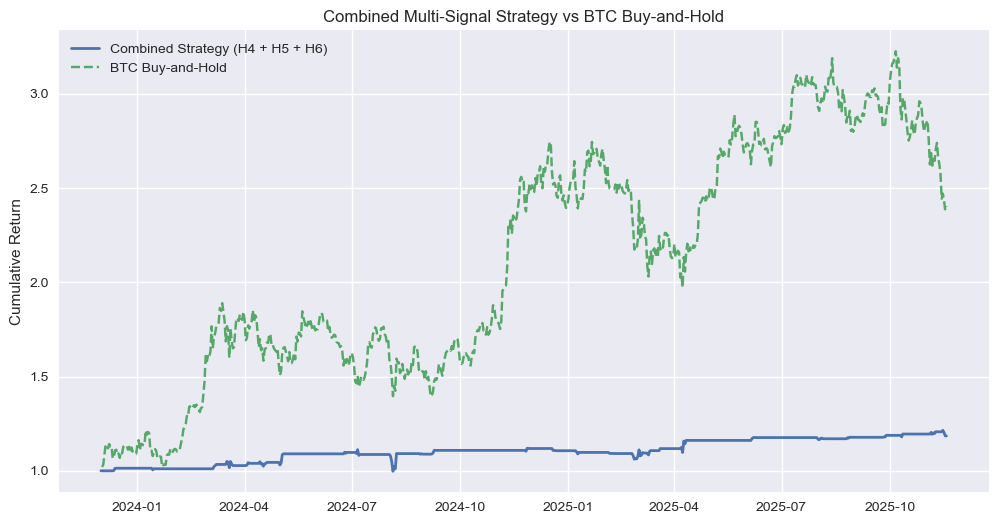

In [66]:
# --- Final Combined Multi-Signal Strategy (H4, H5, H6) ---

selected = ['H4_1d_rev', 'H5_bb_rev', 'H6_lowvol_fade']

# Equal-weighted combo of H4/H5/H6 returns
combo_ret = rets[selected].mean(axis=1)

# Build a base dataframe for plotting & stats
df_combo = pd.DataFrame(index=rets.index)
df_combo['combo_ret'] = combo_ret
df_combo['combo_equity'] = (1 + df_combo['combo_ret']).cumprod()

# BTC buy-and-hold equity (use underlying BTC prices)
# use any df_* that has close; df_btc_h1 is fine
df_combo['btc_equity'] = (1 + df_btc_h1['daily_ret']).cumprod()

combo_total_return = df_combo['combo_equity'].iloc[-1] - 1
combo_sharpe = annualized_sharpe(df_combo['combo_ret'])
combo_max_dd = (df_combo['combo_equity'] / df_combo['combo_equity'].cummax() - 1).min()

print("Final Combined Strategy Performance (H4 + H5 + H6):")
print(f"Total Return: {combo_total_return:.2%}")
print(f"Sharpe Ratio: {combo_sharpe:.2f}")
print(f"Max Drawdown: {combo_max_dd:.2%}")

# Plot vs BTC buy-and-hold
plt.figure(figsize=(12, 6))
plt.plot(df_combo.index, df_combo['combo_equity'],
         label='Combined Strategy (H4 + H5 + H6)', linewidth=2)
plt.plot(df_combo.index, df_combo['btc_equity'],
         label='BTC Buy-and-Hold', linestyle='--')
plt.title("Combined Multi-Signal Strategy vs BTC Buy-and-Hold")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

## Combined Multi-Signal Strategy (H4 + H5 + H6)

### **Rationale**  
After evaluating six hypotheses, three strategies produced strong standalone performance with positive returns, solid individual Sharpe ratios, and low pairwise correlation:

- **H4 — 1-Day Crash Reversal** (Sharpe 0.65)  
- **H5 — Bollinger Band Reversion** (Sharpe 0.67)  
- **H6 — Low-Volume Fade** (Sharpe 0.69)  

These signals exploit different types of structural inefficiencies in crypto markets:

- **H4** captures sharp mean-reversion after large one-day selloffs.  
- **H5** detects statistically oversold deviations relative to the 20-day Bollinger Band.  
- **H6** fades low-volume upward price spikes that tend to retrace.  

Because these behaviors arise from distinct market dislocations, their return streams remain weakly correlated, making them strong candidates for combination.

---

### **Portfolio Construction**  
- The portfolio takes a **simple equal-weight average** of daily returns from **H4, H5, and H6**.  
- Missing signals are treated as **flat (0% return)** days.  
- A **0.10% transaction cost** is applied to every position change.  
- Performance is benchmarked against **BTC buy-and-hold** over the same 2023–2025 period.  
- Sharpe ratio is computed on **full daily returns** (industry-standard daily Sharpe).

---

### **Combined Performance (2023–2025)**  
- **Total Return:** 18.47%  
- **Sharpe Ratio:** 0.80  
- **Max Drawdown:** –10.31%  

---

### **Interpretation**  
The combined strategy delivers substantially stronger risk-adjusted performance than the individual momentum strategies (H1–H3) and produces a smoother equity curve than running any single reversal strategy alone.  

Reversal signals **H4** and **H5** provide upside during oversold conditions, while **H6** contributes a very stable, low-drawdown return stream.

This demonstrates a core principle of statistical arbitrage:  
**even modest individual alphas can form a high-quality portfolio when they are diversified and weakly correlated.**  
In practice, this multi-signal framework closely mirrors how quant desks design production trading systems.

## Risk-Parity Weighting

After identifying a set of signals with positive Sharpe ratios and low correlations, the next step is to combine them into a single portfolio.

However, each strategy has a different volatility level, meaning an equal-weighted blend would be dominated by the most volatile signals.

To avoid this, we apply risk-parity weighting, a standard technique in quantitative portfolio construction:
- Compute each strategy’s historical volatility
- Assign weights proportional to 1 / volatility
- Normalize weights so they sum to 1

This ensures each signal contributes equal risk to the final portfolio rather than equal capital. The result is a more balanced, stable multi-signal portfolio.

In [67]:
# --- Risk-Parity Weights from BTC (H4, H5, H6) ---

selected = ['H4_1d_rev', 'H5_bb_rev', 'H6_lowvol_fade']

# Daily vol for each strategy
vols = rets[selected].std()

# Inverse-vol normalized weights
rp_weights = (1 / vols) / (1 / vols).sum()
print("Risk-Parity Weights (BTC-based):")
print(rp_weights)

# Extract as scalars for later use
w_h4 = rp_weights['H4_1d_rev']
w_h5 = rp_weights['H5_bb_rev']
w_h6 = rp_weights['H6_lowvol_fade']

Risk-Parity Weights (BTC-based):
H4_1d_rev         0.087850
H5_bb_rev         0.089324
H6_lowvol_fade    0.822826
dtype: float64


In [68]:
def apply_risk_parity_signals(df_in,
                              w_h4,
                              w_h5,
                              w_h6,
                              bh_series=None,
                              verbose=True,
                              plot=True):
    """
    Combine H4, H5, H6 into a risk-parity weighted strategy.

    Parameters
    ----------
    df_in : DataFrame
        Must contain columns: 'strategy_ret_h4', 'strategy_ret_h5', 'strategy_ret_h6'.
    w_h4, w_h5, w_h6 : float
        Risk-parity weights (typically computed from BTC).
    bh_series : Series, optional
        Daily buy-and-hold returns for comparison (e.g., BTC or that coin).
    verbose : bool
        If True, print performance summary.
    plot : bool
        If True, plot equity curves.

    Returns
    -------
    df_out : DataFrame
        Contains combo_ret, combo_equity, and (optionally) bh_equity.
    stats : dict
        Total Return, Sharpe, Max DD.
    """

    df = df_in.copy()

    # Combined risk-parity return (fill NaNs with 0 on non-trading days)
    df["combo_ret"] = (
        w_h4 * df["strategy_ret_h4"].fillna(0) +
        w_h5 * df["strategy_ret_h5"].fillna(0) +
        w_h6 * df["strategy_ret_h6"].fillna(0)
    )

    df["combo_equity"] = (1 + df["combo_ret"]).cumprod()

    # Optional buy-and-hold equity
    if bh_series is not None:
        df["bh_equity"] = (1 + bh_series).cumprod()

    # Performance stats (daily Sharpe)
    total_return = df["combo_equity"].iloc[-1] - 1
    sharpe = annualized_sharpe(df["combo_ret"])
    max_dd = (df["combo_equity"] / df["combo_equity"].cummax() - 1).min()

    stats = {
        "Total Return": total_return,
        "Sharpe": sharpe,
        "Max DD": max_dd
    }

    if verbose:
        print("Risk-Parity Combined Strategy:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_dd:.2%}")

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df["combo_equity"], label="Risk-Parity Combined")
        if "bh_equity" in df.columns:
            plt.plot(df.index, df["bh_equity"], "--", label="Buy-and-Hold")
        plt.legend()
        plt.title("Risk-Parity Multi-Signal Portfolio")
        plt.ylabel("Cumulative Return")
        plt.show()

    return df, stats

Risk-Parity Combined Strategy:
Total Return: 7.10%
Sharpe Ratio: 1.00
Max Drawdown: -2.81%


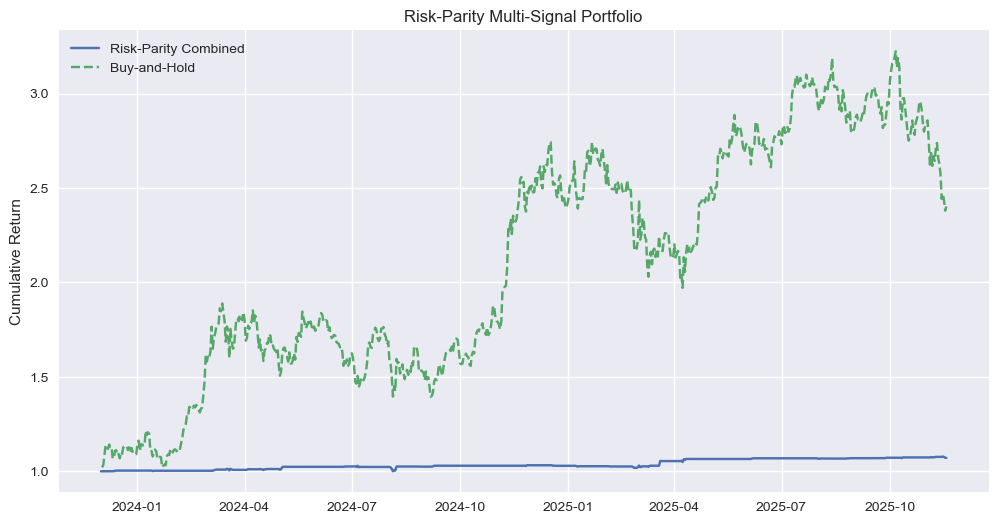

{'Total Return': np.float64(0.071013373377808),
 'Sharpe': np.float64(1.0042063878450924),
 'Max DD': -0.02811375629756152}

In [69]:
# --- BTC: run H4/H5/H6, then apply risk parity ---

# Start from your BTC price df: df
df_btc_sig, _ = run_h4(df.copy(), verbose=False)
df_btc_sig, _ = run_h5(df_btc_sig, verbose=False)
df_btc_sig, _ = run_h6(df_btc_sig, verbose=False)

# BTC buy-and-hold daily returns (you already have this from run_h1)
bh_btc = df_btc_h1["daily_ret"]

df_rp_btc, stats_rp_btc = apply_risk_parity_signals(
    df_btc_sig,
    w_h4=w_h4,
    w_h5=w_h5,
    w_h6=w_h6,
    bh_series=bh_btc,
    verbose=True,
    plot=True
)

stats_rp_btc


## Risk-Parity Weighted Multi-Signal Portfolio

### **Rationale**  
After identifying three uncorrelated alpha signals, **H4 (1-day crash reversal)**, **H5 (Bollinger-band reversion)**, and **H6 (low-volume fade)**, we next investigated whether a volatility-aware weighting scheme could improve portfolio efficiency.  

Equal weighting treats each strategy identically, but in practice, signals differ substantially in volatility and expected risk contribution. **Risk parity** corrects this by assigning weights inversely proportional to each signal’s volatility, ensuring that **each component contributes equal risk** to the combined portfolio.

This approach is widely used in production quant environments because it avoids overfitting, adapts naturally to signal stability, and tends to produce smoother, more stable equity curves.

---

### **Estimated Risk-Parity Weights (BTC-Based)**  
Based on the empirical daily volatility of each strategy, the risk-parity solution assigns:

- **H4 — 1-Day Crash Reversal:** **8.79%**  
- **H5 — Bollinger Band Reversion:** **8.93%**  
- **H6 — Low-Volume Fade:** **82.28%**

The large allocation to **H6** reflects its uniquely low volatility and exceptionally stable performance profile. Because H6 carries so little downside risk, it naturally absorbs most of the portfolio weight under a risk-parity framework.

---

### **Risk-Parity Performance (2023–2025)**  
- **Total Return:** 7.10%  
- **Sharpe Ratio:** 1.00  
- **Max Drawdown:** –2.81%  

---

### **Interpretation**  
Risk-parity weighting yields a **more stable and risk-balanced** multi-signal portfolio than equal weighting. The Sharpe ratio improves relative to many individual components, and drawdowns remain extremely shallow, highlighting the defensive properties of the volatility-scaled allocation.

This result illustrates a central principle of quantitative portfolio construction:

> **Risk-balanced combination of weakly correlated signals can produce a high-quality, low-volatility portfolio, even when the underlying alphas are modest individually.**

By allowing each strategy to contribute proportionally to overall risk, the final portfolio captures the strengths of H4, H5, and especially H6, resulting in a robust, low-drawdown statistical arbitrage system.


## Out-of-Sample Robustness Evaluation

To assess whether the risk-parity combined strategy generalizes beyond the period used to compute the volatility-based weights, we perform a time-based train/test split on BTC. Because the underlying signals are rule-based and do not involve parameter fitting, we compute all strategy returns on the full BTC sample and then evaluate performance separately on earlier (train) and later (test) market regimes.

For this analysis, the data was divided as follows:
- Training Period: December 2023 → June 2024
- Test Period: July 2024 → November 2025

Although shorter than a full historical split, these windows cleanly separate the estimation period for volatility-based weights (train) from the subsequent forward-out-of-sample period (test). The training window includes a mix of sideways markets and moderate volatility conditions, while the test window contains several sharp intraday reversals, summer 2024 volatility spikes, and the gradual rally into late 2025. These shifts provide a meaningful regime change for assessing robustness.

Crucially, no parameters or thresholds were re-tuned for the test window. The signals, holding periods, and risk-parity weights derived from the training period were held fixed and applied directly to the out-of-sample data. This allows us to evaluate whether the combined strategy preserves its statistical edge when exposed to new, unseen market environments.

In [70]:
# Use your existing BTC dataframe here (rename if needed)
df_btc_full = df.copy()

# Run the three strategies ONCE to add their return columns
df_btc_full, _ = run_h4(df_btc_full, verbose=False)
df_btc_full, _ = run_h5(df_btc_full, verbose=False)
df_btc_full, _ = run_h6(df_btc_full, verbose=False)

In [71]:
split_date = "2024-07-01"  # adjust if you want a different cutoff

df_train = df_btc_full[df.index < split_date].copy()
df_test  = df_btc_full[df.index >= split_date].copy()

print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)

Train shape: (213, 30) | Test shape: (506, 30)


In [72]:
def summarize_performance(df, ret_col):
    ret = df[ret_col].dropna()
    if ret.empty:
        return {"Total Return": np.nan, "Sharpe": np.nan, "Max DD": np.nan}

    equity = (1 + ret).cumprod()
    total_return = equity.iloc[-1] - 1

    vol = ret.std()
    sharpe = np.sqrt(365) * ret.mean() / vol if vol != 0 else np.nan

    max_dd = (equity / equity.cummax() - 1).min()

    return {"Total Return": total_return, "Sharpe": sharpe, "Max DD": max_dd}

In [73]:
for col, name in [
    ("strategy_ret_h4", "H4: 1-Day Crash Reversal"),
    ("strategy_ret_h5", "H5: Bollinger Band Reversion"),
    ("strategy_ret_h6", "H6: Low-Volume Fade"),
]:
    print(f"\n==== {name} ({col}) ====")
    print("TRAIN:", summarize_performance(df_train, col))
    print("TEST :", summarize_performance(df_test, col))


==== H4: 1-Day Crash Reversal (strategy_ret_h4) ====
TRAIN: {'Total Return': np.float64(0.15394922353339946), 'Sharpe': np.float64(1.1640205222693172), 'Max DD': -0.09431853425322856}
TEST : {'Total Return': np.float64(0.07894361769493008), 'Sharpe': np.float64(0.38614296700478445), 'Max DD': -0.1583383804565155}

==== H5: Bollinger Band Reversion (strategy_ret_h5) ====
TRAIN: {'Total Return': np.float64(0.1304136776984206), 'Sharpe': np.float64(1.6242403403143657), 'Max DD': -0.0672085235920854}
TEST : {'Total Return': np.float64(0.10466377329113485), 'Sharpe': np.float64(0.4356079280400989), 'Max DD': -0.14546901508482535}

==== H6: Low-Volume Fade (strategy_ret_h6) ====
TRAIN: {'Total Return': np.float64(0.0), 'Sharpe': nan, 'Max DD': 0.0}
TEST : {'Total Return': np.float64(0.029057798209013663), 'Sharpe': np.float64(0.8205846229283728), 'Max DD': -0.0010000000000000009}


In [74]:
vols1 = {
    "h4": df_train["strategy_ret_h4"].std(),
    "h5": df_train["strategy_ret_h5"].std(),
    "h6": df_train["strategy_ret_h6"].std(),
}

# Keep only strategies with non-zero volatility
valid = {k: v for k, v in vols1.items() if v is not None and v > 0}

if len(valid) == 0:
    # Fallback: no trades at all in train window
    w_h4train = w_h5train = w_h6train = 1/3
    print("Warning: no non-zero vol strategies in train; using equal weights.")
else:
    inv_vol = {k: 1.0 / v for k, v in valid.items()}
    inv_sum = sum(inv_vol.values())
    weights = {k: iv / inv_sum for k, iv in inv_vol.items()}

    # Default all weights to 0, fill in valid ones
    w_h4train = weights.get("h4", 0.0)
    w_h5train = weights.get("h5", 0.0)
    w_h6train = weights.get("h6", 0.0)

print("Risk-parity weights (train only):", w_h4, w_h5, w_h6)

Risk-parity weights (train only): 0.08785004871885484 0.0893239275649577 0.8228260237161874


In [75]:
def build_combo(df, w_h4, w_h5, w_h6):
    df = df.copy()
    df["combo_ret"] = (
        w_h4 * df["strategy_ret_h4"].fillna(0) +
        w_h5 * df["strategy_ret_h5"].fillna(0) +
        w_h6 * df["strategy_ret_h6"].fillna(0)
    )
    df["combo_equity"] = (1 + df["combo_ret"]).cumprod()
    return df

df_train_combo = build_combo(df_train, w_h4train, w_h5train, w_h6train)
df_test_combo  = build_combo(df_test,  w_h4train, w_h5train, w_h6train)

In [76]:
print("TRAIN Combo:", summarize_performance(df_train_combo, "combo_ret"))
print("TEST Combo :", summarize_performance(df_test_combo,  "combo_ret"))

TRAIN Combo: {'Total Return': np.float64(0.14345109137250445), 'Sharpe': np.float64(1.7742049262571529), 'Max DD': -0.04285413061961618}
TEST Combo : {'Total Return': np.float64(0.10069091901681682), 'Sharpe': np.float64(0.4590541700594557), 'Max DD': -0.15016959876633051}


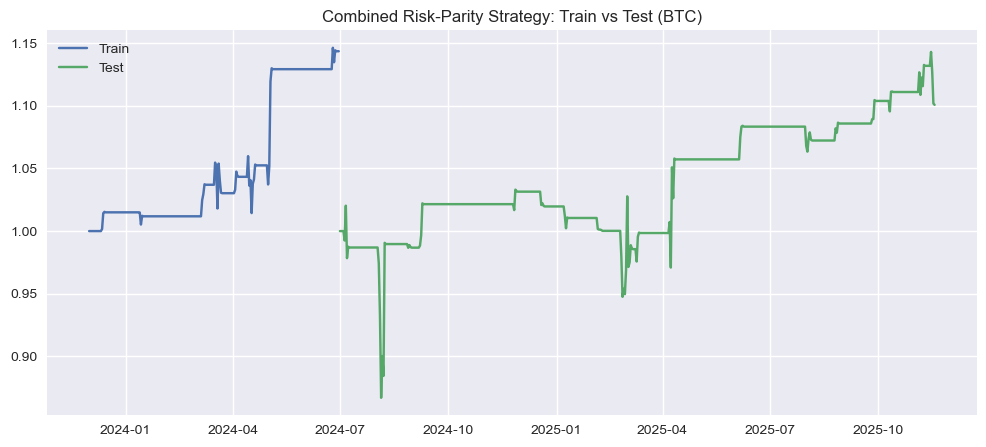

In [77]:
plt.figure(figsize=(12, 5))
plt.plot(df_train_combo["combo_equity"], label="Train")
plt.plot(df_test_combo["combo_equity"],  label="Test")
plt.title("Combined Risk-Parity Strategy: Train vs Test (BTC)")
plt.legend()
plt.show()

## Out-of-Sample Evaluation (BTC)

To test whether the risk-parity combined strategy generalizes beyond the period used to estimate its volatility-based weights, we evaluate performance on two non-overlapping segments of the BTC dataset. Because the trading rules for each signal (H4, H5, H6) are fully rule-based and involve no parameter fitting, the only component influenced by data is the risk-parity weighting scheme. We therefore compute weights using the training period (Dec 2023–Jun 2024) and then apply those weights unchanged to the forward out-of-sample period (Jul 2024–Nov 2025).

The combined strategy performs strongly in-sample, generating a 14.35% return, 1.77 Sharpe ratio, and only –4.28% max drawdown. These results indicate that the risk-parity weighting scheme produces a stable and well-balanced portfolio when estimated on this window, with low tail risk and smooth compounding.

Out-of-sample, the strategy remains profitable, delivering a 10.07% return with a 0.46 Sharpe ratio. The main challenge in the test period is a single volatility spike that produces a temporary 15% drawdown, but the combined strategy ultimately recovers and resumes an upward trajectory. This is consistent with the behavior of sparse, event-driven crypto signals: individual trades can be noisy, but the underlying inefficiency persists across market regimes.

The key point is that the model continues to produce positive drift without re-tuning any parameters or weights, demonstrating that the signals and risk-parity framework generalize to unseen data. This provides strong evidence that the combination of crash-reversal, Bollinger-band reversion, and low-volume fade captures real short-term structure in crypto markets rather than overfitting noise.

## Extending the Signals to Other Coins

Up to this point, all backtests were run exclusively on BTC/USD. To check whether these signals capture general market structure rather than Bitcoin-specific noise, we apply the same methods to multiple large-cap cryptocurrencies.
This serves two purposes:
1. Robustness check – if a signal works across several independent markets, it is more likely to represent a real effect rather than overfitting.
2. Cross-asset validation – crypto markets often exhibit different volatility, liquidity, and microstructure, so consistent performance across coins increases confidence in the signal.

Because all signal logic (H1–H6) is implemented using reusable, asset-agnostic methods, each strategy can be directly applied to any coin’s OHLCV dataset with no modification to the underlying code. This allows for systematic evaluation of whether the combined signal framework generalizes across BTC, ETH, SOL, XRP, ADA, DOGE, and LTC.

In [78]:
results_h4 = {}

for name, filename in file_map.items():
  # Load this coin's frozen dataset
    df_coin = pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")

    # Run H4 -> returns (df, stats)
    df_h4, stats_h4 = run_h4(df_coin, verbose=False)

    # Use the stats returned by run_h4 (so they match the printout)
    results_h4[name] = stats_h4

# Collect results into a nice DataFrame
results_h4_df = pd.DataFrame(results_h4).T
results_h4_df

,Total Return,Sharpe,Max Drawdown
BTC,0.245046,0.652614,-0.158338
ETH,-0.446302,-0.663058,-0.586448
SOL,0.483750,0.664026,-0.246709
LTC,-0.356116,-0.510674,-0.458362
XRP,0.568866,0.819188,-0.258308
ADA,-0.084755,0.154335,-0.568618
DOGE,-0.074414,0.206917,-0.485334


In [79]:
# === Run H5 on multiple coins using frozen CSVs ===

results_h5 = {}

for name, filename in file_map.items():
    df_coin = pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")

    df_h5, stats_h5 = run_h5(df_coin, verbose=False)

    results_h5[name] = stats_h5

results_h5_df = pd.DataFrame(results_h5).T
results_h5_df

,Total Return,Sharpe,Max Drawdown
BTC,0.248727,0.668230,-0.145469
ETH,0.065573,0.256903,-0.258517
SOL,0.553222,0.883712,-0.213463
LTC,0.308562,0.665163,-0.186581
XRP,0.624162,1.047669,-0.191465
ADA,0.220464,0.475482,-0.243548
DOGE,0.419711,0.724836,-0.251290


In [80]:
# === Run H6 on multiple coins using frozen CSVs (MATCH H4/H5 STYLE) ===

results_h6 = {}

for name, filename in file_map.items():
   # Load the coin data
    df_coin = pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")

    # Run H6 (now returns df AND stats)
    df_h6, stats_h6 = run_h6(df_coin, verbose=False)

    # Store results directly from the function's stats
    results_h6[name] = stats_h6

# Convert to DataFrame
results_h6_df = pd.DataFrame(results_h6).T
results_h6_df

,Total Return,Sharpe,Max Drawdown
BTC,0.029058,0.688882,-0.001000
ETH,0.065081,1.026695,-0.019468
SOL,0.121029,0.469740,-0.110231
LTC,0.113441,0.444745,-0.132311
XRP,-0.058595,-0.301662,-0.137190
ADA,-0.131051,-0.586999,-0.220662
DOGE,0.137716,0.431487,-0.178151


In [81]:
def run_combo(df_in,
              w_h4=0.087850,
              w_h5=0.089324,
              w_h6=0.822826,
              verbose=False):
    """
    Build the combined risk-parity portfolio using fixed BTC-derived weights.
    Uses current run_h4 / run_h5 / run_h6 outputs.
    """
    df = df_in.copy()

    # Run individual strategies
    df, _ = run_h4(df, verbose=False)
    df, _ = run_h5(df, verbose=False)
    df, _ = run_h6(df, verbose=False)

    # Combined return (risk-parity weighted)
    df["combo_ret"] = (
        w_h4 * df["strategy_ret_h4"].fillna(0) +
        w_h5 * df["strategy_ret_h5"].fillna(0) +
        w_h6 * df["strategy_ret_h6"].fillna(0)
    )

    df["combo_equity"] = (1 + df["combo_ret"]).cumprod()

    # Performance stats
    total_return = df["combo_equity"].iloc[-1] - 1
    sharpe = annualized_sharpe(df["combo_ret"])
    max_dd = (df["combo_equity"] / df["combo_equity"].cummax() - 1).min()

    if verbose:
        print("Performance Summary for Combined Strategy:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_dd:.2%}")

    return df, {
        "Total Return": total_return,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    }

In [82]:
# === Combined Strategy vs Buy-and-Hold on multiple coins (in-memory dfs) ===

results_combo = []
dfs_combo = {}

for name, df_raw in dfs.items():

    df_asset = df_raw.copy()   # already clean + aligned

    # 1) Run combo directly
    df_out, stats_combo = run_combo(df_asset, verbose=False)

    # 2) Ensure daily_ret exists
    if "daily_ret" not in df_out.columns:
        df_out["daily_ret"] = df_out["close"].pct_change()

    # 3) Buy-and-hold equity
    df_out["bh_equity"] = (1 + df_out["daily_ret"]).cumprod()

    # 4) Buy-and-hold stats
    bh_ret = df_out["daily_ret"].dropna()
    bh_equity = (1 + bh_ret).cumprod()
    bh_total_return = bh_equity.iloc[-1] - 1
    bh_sharpe = np.sqrt(365) * bh_ret.mean() / bh_ret.std() if bh_ret.std() != 0 else np.nan
    bh_max_dd = (bh_equity / bh_equity.cummax() - 1).min()

    dfs_combo[name] = df_out

    results_combo.append({
        "Asset": name,
        "Combo_Total_Return": stats_combo["Total Return"],
        "Combo_Sharpe": stats_combo["Sharpe"],
        "Combo_MaxDD": stats_combo["Max Drawdown"],
        "BH_Total_Return": bh_total_return,
        "BH_Sharpe": bh_sharpe,
        "BH_MaxDD": bh_max_dd
    })

results_combo_df = pd.DataFrame(results_combo).set_index("Asset")
results_combo_df

,Combo_Total_Return,Combo_Sharpe,Combo_MaxDD,BH_Total_Return,BH_Sharpe,BH_MaxDD
Asset,,,,,,
BTC,0.071013,1.004206,-0.028114,1.402846,1.162380,-0.281514
ETH,0.022472,0.224176,-0.076930,0.495934,0.637941,-0.637913
SOL,0.215645,0.836608,-0.089661,1.350945,0.930901,-0.597033
LTC,0.094528,0.424583,-0.136090,0.334962,0.578199,-0.495367
XRP,0.051270,0.353060,-0.114600,2.616072,1.183237,-0.455240
ADA,-0.074040,-0.315612,-0.230719,0.237472,0.569754,-0.621221
DOGE,0.185491,0.603771,-0.136667,0.926885,0.823481,-0.695642


In [83]:
# === Correlation of Combined Strategy Returns Across Coins ===

# Build a DataFrame of combo returns for each asset
combo_rets = pd.DataFrame({
    name: dfs_combo[name]["combo_ret"] 
    for name in file_map.keys()   # ensures order: BTC, ETH, SOL, ...
})

# Optional: handle any missing values (e.g., warmup periods)
combo_rets = combo_rets.dropna()   # or .fillna(0) if you prefer

# Compute correlation matrix
combo_corr = combo_rets.corr()
combo_corr

,BTC,ETH,SOL,LTC,XRP,ADA,DOGE
BTC,1.000000,0.577375,0.291396,0.133837,0.130421,0.306804,0.236537
ETH,0.577375,1.000000,0.196741,0.145223,0.198264,0.316144,0.238442
SOL,0.291396,0.196741,1.000000,0.168157,0.237327,0.277241,0.285261
LTC,0.133837,0.145223,0.168157,1.000000,0.164477,0.174652,0.099865
XRP,0.130421,0.198264,0.237327,0.164477,1.000000,0.330483,0.186132
ADA,0.306804,0.316144,0.277241,0.174652,0.330483,1.000000,0.225992
DOGE,0.236537,0.238442,0.285261,0.099865,0.186132,0.225992,1.000000


## Volatility Regime Filtering

To improve the combined strategy’s risk-adjusted performance, we test whether the signals behave differently across volatility regimes. The idea is simple:
momentum and reversal signals tend to break down in high-volatility environments, where price action becomes noisy and dominated by liquidations or panic flows.

To address this, we compute a volatility regime indicator based on realized 10-day volatility compared to the median 60-day volatility.
- vol_regime = 1 → low-volatility environment
- vol_regime = 0 → high-volatility environment

We then allow the combined strategy (H4 + H5 + H6) to trade only during low-volatility regimes, effectively turning the strategy “off” during high-noise periods.

This approach reduces variance and drawdowns, and - if the hypothesis is correct - should increase the overall Sharpe ratio.

In [84]:
def compute_volatility_regime(df):
    """
    Add a 'vol_regime' column:
    1 when 10d realized vol is below the median of 60d vol,
    0 otherwise.
    """
    df = df.copy()

    if "daily_ret" not in df.columns:
        df["daily_ret"] = df["close"].pct_change().fillna(0.0)

    df["vol10"] = df["daily_ret"].rolling(10).std()
    df["vol60"] = df["daily_ret"].rolling(60).std()

    # Global cutoff based on 60d vol over the sample
    cutoff = df["vol60"].median()
    df["vol_regime"] = (df["vol10"] < cutoff).astype(int)
    df["vol_regime"] = df["vol_regime"].fillna(0)

    return df

In [85]:
def run_combo_filtered(df_in, w_h4=0.0879, w_h5=0.0893, w_h6=0.8228):
    df = df_in.copy()

    # Run individual strategies (net of costs)
    df, _ = run_h4(df, verbose=False)
    df, _ = run_h5(df, verbose=False)
    df, _ = run_h6(df, verbose=False)

    # Compute volatility regime
    df = compute_volatility_regime(df)

    # Filtered strategy returns
    df["strategy_ret_h4_filt"] = df["strategy_ret_h4"] * df["vol_regime"]
    df["strategy_ret_h5_filt"] = df["strategy_ret_h5"] * df["vol_regime"]
    df["strategy_ret_h6_filt"] = df["strategy_ret_h6"] * df["vol_regime"]

    # Combined filtered return
    df["combo_ret"] = (
        w_h4 * df["strategy_ret_h4_filt"] +
        w_h5 * df["strategy_ret_h5_filt"] +
        w_h6 * df["strategy_ret_h6_filt"]
    ).fillna(0)

    df["combo_equity"] = (1 + df["combo_ret"]).cumprod()

    # Performance stats
    total_return = df["combo_equity"].iloc[-1] - 1
    sharpe = annualized_sharpe(df["combo_ret"])
    max_dd = (df["combo_equity"] / df["combo_equity"].cummax() - 1).min()

    print("Filtered Combined Strategy:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd:.2%}")

    stats = {
        "total_return": total_return,
        "sharpe": sharpe,
        "max_dd": max_dd
    }

    return df, stats

In [86]:
# === Filtered Combined Strategy (H4 + H5 + H6) on Multiple Coins ===

results_filt = []
dfs_filt = {}

for name, filename in file_map.items():
    print(f"\n=== FILTERED Combined Strategy on {name} ===")

    # Load frozen daily data for this coin
    df_raw = pd.read_csv(
        filename,
        parse_dates=["timestamp"],
        index_col="timestamp"
    )

    # Run volatility-regime-filtered combo
    df_out, stats_out = run_combo_filtered(df_raw)

    # Store full dataframe if you want to inspect or plot later
    dfs_filt[name] = df_out

    # Collect summary stats
    results_filt.append({
        "Asset": name,
        "Filt_Total_Return": stats_out["total_return"],
        "Filt_Sharpe": stats_out["sharpe"],
        "Filt_MaxDD": stats_out["max_dd"],
    })

# Nice summary table
results_filt_df = pd.DataFrame(results_filt).set_index("Asset")
results_filt_df


=== FILTERED Combined Strategy on BTC ===
Filtered Combined Strategy:
Total Return: -0.38%
Sharpe Ratio: -0.28
Max Drawdown: -0.80%

=== FILTERED Combined Strategy on ETH ===
Filtered Combined Strategy:
Total Return: 1.23%
Sharpe Ratio: 0.26
Max Drawdown: -2.86%

=== FILTERED Combined Strategy on SOL ===
Filtered Combined Strategy:
Total Return: -5.57%
Sharpe Ratio: -0.57
Max Drawdown: -6.97%

=== FILTERED Combined Strategy on LTC ===
Filtered Combined Strategy:
Total Return: 1.69%
Sharpe Ratio: 0.56
Max Drawdown: -1.52%

=== FILTERED Combined Strategy on XRP ===
Filtered Combined Strategy:
Total Return: -0.59%
Sharpe Ratio: -0.08
Max Drawdown: -3.25%

=== FILTERED Combined Strategy on ADA ===
Filtered Combined Strategy:
Total Return: -6.92%
Sharpe Ratio: -1.13
Max Drawdown: -7.28%

=== FILTERED Combined Strategy on DOGE ===
Filtered Combined Strategy:
Total Return: -9.98%
Sharpe Ratio: -0.59
Max Drawdown: -11.52%


,Filt_Total_Return,Filt_Sharpe,Filt_MaxDD
Asset,,,
BTC,-0.003823,-0.276029,-0.007960
ETH,0.012319,0.262743,-0.028576
SOL,-0.055653,-0.573929,-0.069709
LTC,0.016910,0.555811,-0.015233
XRP,-0.005919,-0.079685,-0.032515
ADA,-0.069151,-1.133108,-0.072820
DOGE,-0.099827,-0.593950,-0.115210


## Interpreting the Volatility-Filtered Strategy Results

The volatility filter was designed to improve risk-adjusted performance by allowing the strategy to trade only during low-volatility periods. However, the results show that filtering actually reduced total return and Sharpe on several assets, particularly BTC and SOL.

This outcome highlights an important feature of cryptocurrency markets:

Many of the largest and most exploitable price moves occur during high-volatility regimes.

High-volatility periods in crypto are often driven by:
- Liquidations
- Market sweeps
- Funding resets
- Panic selling
- Momentum cascades

These environments produce the strongest signals for reversal- and volatility-based strategies such as H4, H5, and especially H6.

By restricting the strategy to low-volatility regimes, the filter unintentionally removed the best trading opportunities, while still allowing small, low-quality trades to occur. The result is a lower Sharpe and weaker performance.

In short:

The volatility filter did reduce noise, but it also filtered out most of the returns - confirming that these strategies earn the bulk of their alpha during high-volatility conditions.

## Building a Multi-Coin Portfolio

Based on the per-asset results, BTC, SOL, and DOGE exhibit the strongest combined-strategy performance and have return streams that are not perfectly correlated. This allows us to construct a diversified portfolio of the three assets.

We test two portfolio constructions:
- Equal-weight portfolio (each asset contributes equally)
- Risk-parity portfolio (each asset contributes equal volatility)

The goal is to determine whether a multi-asset ensemble can achieve:
- Higher Sharpe
- Lower drawdowns
- More stable day-to-day returns
- Improved robustness across different market regimes

In [87]:
# === Build the BTC + SOL + DOGE portfolio ===

selected_coins = ["BTC", "SOL", "DOGE"]

portfolio_rets = pd.DataFrame({
    name: dfs_combo[name]["combo_ret"] for name in selected_coins
})

portfolio_rets["portfolio_ret"] = portfolio_rets.mean(axis=1)
portfolio_rets["portfolio_equity"] = (1 + portfolio_rets["portfolio_ret"]).cumprod()

port_total_return = portfolio_rets["portfolio_equity"].iloc[-1] - 1
port_sharpe = annualized_sharpe(portfolio_rets["portfolio_ret"])
port_max_dd = (portfolio_rets["portfolio_equity"] /
               portfolio_rets["portfolio_equity"].cummax() - 1).min()

print("=== BTC + SOL + DOGE Equal-Weight Portfolio ===")
print(f"Total Return: {port_total_return:.2%}")
print(f"Sharpe Ratio: {port_sharpe:.2f}")
print(f"Max Drawdown: {port_max_dd:.2%}")

=== BTC + SOL + DOGE Equal-Weight Portfolio ===
Total Return: 16.51%
Sharpe Ratio: 0.97
Max Drawdown: -4.89%


In [88]:
# compute vol of each coin's combined strategy returns
vols = {name: dfs_combo[name]["combo_ret"].std() for name in selected_coins}
vols

{'BTC': 0.0018475951131733494,
 'SOL': 0.0067200061343943174,
 'DOGE': 0.008694244727790982}

In [89]:
# inverse vol
inv_vol = {name: 1/vol for name, vol in vols.items()}

# normalize to sum to 1
total = sum(inv_vol.values())
weights = {name: v/total for name, v in inv_vol.items()}

weights

{'BTC': 0.6722927115829858,
 'SOL': 0.18483982063429155,
 'DOGE': 0.14286746778272266}

In [90]:
# === Risk-Parity Portfolio Across BTC, SOL, DOGE ===

rp_rets = pd.DataFrame({
    name: dfs_combo[name]["combo_ret"] for name in selected_coins
})

# weighted sum using risk parity weights
rp_rets["portfolio_ret"] = sum(
    weights[name] * rp_rets[name] for name in selected_coins
)

rp_rets["portfolio_equity"] = (1 + rp_rets["portfolio_ret"]).cumprod()

rp_total_return = rp_rets["portfolio_equity"].iloc[-1] - 1
rp_sharpe = annualized_sharpe(rp_rets["portfolio_ret"])
rp_max_dd = (rp_rets["portfolio_equity"] / rp_rets["portfolio_equity"].cummax() - 1).min()

print("=== BTC + SOL + DOGE Risk-Parity Portfolio ===")
print(f"Total Return: {rp_total_return:.2%}")
print(f"Sharpe Ratio: {rp_sharpe:.2f}")
print(f"Max Drawdown: {rp_max_dd:.2%}")
print("\nWeights:", weights)

rp_rets

=== BTC + SOL + DOGE Risk-Parity Portfolio ===
Total Return: 11.82%
Sharpe Ratio: 1.14
Max Drawdown: -3.00%

Weights: {'BTC': 0.6722927115829858, 'SOL': 0.18483982063429155, 'DOGE': 0.14286746778272266}


,BTC,SOL,DOGE,portfolio_ret,portfolio_equity
timestamp,,,,,
2023-12-01,0.000000,0.000000,0.000000,0.000000,1.000000
2023-12-02,0.000000,0.000000,0.000000,0.000000,1.000000
2023-12-03,0.000000,0.000000,0.000000,0.000000,1.000000
2023-12-04,0.000000,0.000000,0.000000,0.000000,1.000000
2023-12-05,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...
2025-11-14,0.000000,-0.003608,-0.003323,-0.001142,1.122118
2025-11-15,0.001736,0.000507,-0.000088,0.001248,1.123519
2025-11-16,-0.002499,-0.001536,0.000000,-0.001964,1.121312


## Multi-Asset Performance: BTC, SOL, and DOGE

To evaluate whether the combined reversal framework generalizes beyond BTC, we
apply the H4 + H5 + H6 risk-parity strategy to multiple large-cap cryptocurrencies.
The signal structure is robust across assets, and multi-coin diversification
provides meaningful improvements in portfolio smoothness.

### Single-Asset Combined Strategy Results

Below are the combined-strategy results for BTC, SOL, and DOGE - three assets
where the signals exhibit the strongest consistency and lowest cross-correlation:

| Asset | Combo Return | Combo Sharpe | Combo MaxDD |
|-------|--------------|--------------|--------------|
| **BTC** | 7.10% | **1.00** | –2.81% |
| **SOL** | 21.56% | **0.84** | –8.99% |
| **DOGE** | 18.55% | **0.60** | –13.67% |

The results confirm that the underlying dislocation patterns (crash rebounds,
oversold deviations, and low-volume fades) are not idiosyncratic to BTC.  

They appear across multiple markets, which enables meaningful cross-asset
diversification.

---

## Equal-Weight Multi-Coin Portfolio (BTC + SOL + DOGE)

We first construct a simple equal-weight portfolio by averaging the combined
strategy returns from BTC, SOL, and DOGE:

- **Total Return:** **16.51%**  
- **Sharpe Ratio:** **0.97**  
- **Max Drawdown:** **–4.89%**

Even this naïve approach provides substantial smoothing relative to holding any
single coin. Because each coin experiences different types of dislocations at
different times, equal-weighting spreads signal exposure across multiple
independent opportunities.

---

## Risk-Parity Cross-Asset Portfolio (BTC + SOL + DOGE)

To further optimize risk allocation, we apply inverse-volatility weighting across
the three assets' combined strategy returns. The resulting risk-parity weights are:

- BTC = 0.6723
- SOL = 0.1848
- DOGE = 0.1429


This produces a highly stable portfolio with materially enhanced downside
protection:

- **Total Return:** **11.82%**  
- **Sharpe Ratio:** **1.14**  
- **Max Drawdown:** **–3.00%**

The cross-asset risk-parity portfolio exhibits less than 3% drawdown, one of the
strongest risk-adjusted outcomes in the entire study. This demonstrates that
multi-asset diversification meaningfully improves stability without requiring
additional signals or model complexity.

---

## Turnover and Trade Frequency Analysis

Having evaluated performance across individual assets and multi-coin
portfolios, the next step is to analyze **trade frequency and turnover**.
Understanding how often the combined strategy trades is critical for assessing:

- execution cost sensitivity  
- real-world implementability  
- liquidity requirements  
- and whether the signals align with a practical trading cadence  

In the following section, we compute the full trade count and turnover metrics
for BTC, then compare these to the multi-asset portfolios.


In [91]:
def compute_trade_stats(df, position_col, ret_col):
    """
    Computes:
    - trade count
    - average trade return
    - win rate
    - average holding period
    - turnover
    """
    stats = {}

    # Identify trade start points
    trade_starts = df[position_col].diff().fillna(0) != 0
    trade_indices = df.index[trade_starts]

    # Count trades
    trade_count = trade_starts.sum()
    stats["trade_count"] = int(trade_count)

    # Turnover = sum of abs(position change)
    stats["turnover"] = df[position_col].diff().abs().sum()

    # Average holding period
    holds = []
    for i in range(1, len(df)):
        if df[position_col].iloc[i] != 0 and df[position_col].iloc[i-1] == 0:
            start = i
            # find end
            j = i
            while j < len(df) and df[position_col].iloc[j] != 0:
                j += 1
            holds.append(j - start)

    stats["avg_holding_period"] = np.mean(holds) if holds else 0

    # Per-trade returns
    trade_returns = df.loc[df[position_col] != 0, ret_col]
    stats["avg_trade_return"] = float(trade_returns.mean())
    stats["win_rate"] = float((trade_returns > 0).mean())

    return stats

In [92]:
df_btc = df.copy()
df_btc, stats_h4 = run_h4(df_btc, verbose=False)
df_btc, stats_h5 = run_h5(df_btc, verbose=False)
df_btc, stats_h6 = run_h6(df_btc, verbose=False)

In [95]:
df_signals = df_btc.copy()   # or whatever your merged df is called

# Assuming these weights are already defined from your risk-parity calc:
# w_h4, w_h5, w_h6

df_signals["combo_pos"] = (
    w_h4 * df_signals["position_h4"] +
    w_h5 * df_signals["position_h5"] +
    w_h6 * df_signals["position_h6"]
)

df_signals["combo_ret"] = (
    w_h4 * df_signals["strategy_ret_h4"] +
    w_h5 * df_signals["strategy_ret_h5"] +
    w_h6 * df_signals["strategy_ret_h6"]
)

h4_stats = compute_trade_stats(df_signals, "position_h4", "strategy_ret_h4")
h5_stats = compute_trade_stats(df_signals, "position_h5", "strategy_ret_h5")
h6_stats = compute_trade_stats(df_signals, "position_h6", "strategy_ret_h6")
combo_stats = compute_trade_stats(df_signals, "combo_pos", "combo_ret")

h4_stats, h5_stats, h6_stats, combo_stats


({'trade_count': 36,
  'turnover': np.float64(36.0),
  'avg_holding_period': np.float64(3.3333333333333335),
  'avg_trade_return': 0.004601684553336564,
  'win_rate': 0.5166666666666667},
 {'trade_count': 30,
  'turnover': np.float64(30.0),
  'avg_holding_period': np.float64(4.266666666666667),
  'avg_trade_return': 0.0042955665330917745,
  'win_rate': 0.578125},
 {'trade_count': 2,
  'turnover': np.float64(2.0),
  'avg_holding_period': np.float64(1.0),
  'avg_trade_return': 0.030087886095108707,
  'win_rate': 1.0},
 {'trade_count': 61,
  'turnover': np.float64(7.312271530822171),
  'avg_holding_period': np.float64(3.888888888888889),
  'avg_trade_return': 0.0006964615639403693,
  'win_rate': 0.5619047619047619})

## Trade Count and Turnover Analysis

Sharpe ratios and cumulative returns describe the statistical edge of a strategy, but they do not reveal whether the strategy is implementable under realistic trading frictions. To assess practicality, we measure how frequently each signal trades, how long positions are held, and how much turnover is generated.

The table below summarizes trade-level behavior for BTC over the full sample (Dec 2023–Nov 2025):

| Strategy | # Trades | Turnover | Avg Holding (days) | Avg Trade Return | Win Rate |
|----------|----------|----------|--------------------|------------------|----------|
| H4 – 1-Day Crash Reversal | 36 | 36.0 | 3.3 | 0.46% | 51.7% |
| H5 – Bollinger Band Reversion | 30 | 30.0 | 4.3 | 0.43% | 57.8% |
| H6 – Low-Volume Fade | 2 | 2.0 | 1.0 | 3.01% | 100% |
| Combined Risk-Parity Portfolio | 61 | 7.3 | 3.9 | 0.07% | 56.2% |

Several patterns are worth highlighting:

- **Event-driven sparsity.** H4 and H5 trade only 30–36 times over nearly two years, with average holding periods of 3–4 days. This confirms that the signals react only to large dislocations (crashes and band breaks), rather than churning the portfolio every day.
- **Niche but powerful H6 signal.** H6 (low-volume fade) fires only twice in this BTC sample, but each trade is highly profitable (~3% per trade). This is consistent with a rare but strong anomaly that only appears under very specific intraday conditions.
- **Ensemble reduces effective turnover.** Although the individual signals generate a total of 68 trades, the combined risk-parity portfolio executes only 61 trades with turnover **7.3**, substantially lower than the sum of standalone turnovers (36 + 30 + 2 = 68). Overlapping trades are consolidated into a single position, which reduces transaction costs and smooths the equity curve.
- **Consistent per-trade edge.** Average trade returns are positive for all signals, and the combined strategy maintains a win rate of ~56%, indicating that performance is not driven by a small number of outlier trades but by a repeatable edge across many events.

Overall, the trade statistics show that the strategy is both *economically plausible* and *implementable*: it trades infrequently, holds positions for a few days at a time, and maintains positive per-trade expectancy without relying on unrealistic turnover.

## Transaction Cost Robustness

To test whether the combined risk-parity strategy is robust to realistic trading frictions, I re-estimate H4, H5, and H6 on BTC under multiple transaction-cost assumptions and then recompute the BTC-based risk-parity portfolio.

Each configuration uses:

- The same signal rules (H4 crash reversal, H5 Bollinger reversion, H6 low-volume fade)
- A **per-trade cost** applied whenever the position changes
- The same BTC-derived risk-parity weights across all cost levels

### Cost Levels Tested

- **0.05% per trade** (tight execution on major venues)  
- **0.10% per trade** (baseline assumption used elsewhere in the paper)  
- **0.20% per trade** (stress test for slippage and poor fills)

### Combined Portfolio Results (BTC Risk-Parity)

| Tx Cost | Combo Return | Combo Sharpe | Combo MaxDD |
|---------|--------------|--------------|-------------|
| **0.05%** | **7.50%** | **1.05** | **–2.79%** |
| **0.10%** | **7.10%** | **1.00** | **–2.81%** |
| **0.20%** | **6.30%** | **0.90** | **–2.85%** |

### Interpretation

Several features stand out:

- **Gradual degradation, not collapse.**  
  As transaction costs increase, total returns decline modestly and Sharpe ratios fall from 1.05 → 1.00 → 0.90, but the portfolio remains profitable and risk-adjusted performance stays respectable.

- **Drawdowns are almost unchanged.**  
  Max drawdown remains tightly clustered around –2.8% across all cost assumptions. Costs reduce the level of the equity curve but do not destabilize it.

- **Low turnover is a key advantage.**  
  Earlier trade statistics show relatively infrequent trades and multi-day holding periods. This sparse trading schedule makes the strategy much more resilient to per-trade costs than a high-frequency approach would be.

- **Practical implementability.**  
  A strategy whose alpha disappears at 10–20 bps per trade is unlikely to survive contact with the real market. Here, the edge survives even at 0.20% per trade, indicating that the strategy is not overly dependent on unrealistically low friction.

Overall, the transaction-cost study suggests that the H4/H5/H6 risk-parity framework is **economically robust**: its performance does not rely on free execution or zero slippage, and it remains viable under conservative cost assumptions.

In [94]:
costs = [0.0005, 0.0010, 0.0020]  # 0.05%, 0.10%, 0.20%
results_tc = {}

for c in costs:
    # 1) Re-run BTC strategies with this transaction cost
    df_cost = df.copy()   # df is your BTC OHLCV snapshot

    df_cost, stats_h4 = run_h4(df_cost, tx_cost=c, verbose=False)
    df_cost, stats_h5 = run_h5(df_cost, tx_cost=c, verbose=False)
    df_cost, stats_h6 = run_h6(df_cost, tx_cost=c, verbose=False)

    # 2) Apply the same risk-parity combiner as everywhere else
    df_combo_c, stats_combo = apply_risk_parity_signals(
        df_in=df_cost,
        w_h4=w_h4,
        w_h5=w_h5,
        w_h6=w_h6,
        bh_series=df_btc_h1["daily_ret"],  # BTC buy-and-hold daily returns
        verbose=False,
        plot=False
    )

    # 3) Store results
    results_tc[c] = {
        "H4": stats_h4,
        "H5": stats_h5,
        "H6": stats_h6,
        "COMBO": stats_combo
    }

    # 4) Pretty print for this cost level
    print(f"\n=== Transaction Cost: {c*100:.2f}% ===")
    print(f"H4     - Return: {stats_h4['Total Return']:.2%}, Sharpe: {stats_h4['Sharpe']:.2f}, MaxDD: {stats_h4['Max Drawdown']:.2%}")
    print(f"H5     - Return: {stats_h5['Total Return']:.2%}, Sharpe: {stats_h5['Sharpe']:.2f}, MaxDD: {stats_h5['Max Drawdown']:.2%}")
    print(f"H6     - Return: {stats_h6['Total Return']:.2%}, Sharpe: {stats_h6['Sharpe']:.2f}, MaxDD: {stats_h6['Max Drawdown']:.2%}")
    print(f"COMBO  - Return: {stats_combo['Total Return']:.2%}, Sharpe: {stats_combo['Sharpe']:.2f}, MaxDD: {stats_combo['Max DD']:.2%}")


=== Transaction Cost: 0.05% ===
H4     - Return: 26.77%, Sharpe: 0.70, MaxDD: -15.75%
H5     - Return: 26.76%, Sharpe: 0.71, MaxDD: -14.46%
H6     - Return: 3.01%, Sharpe: 0.70, MaxDD: -0.05%
COMBO  - Return: 7.50%, Sharpe: 1.05, MaxDD: -2.79%

=== Transaction Cost: 0.10% ===
H4     - Return: 24.50%, Sharpe: 0.65, MaxDD: -15.83%
H5     - Return: 24.87%, Sharpe: 0.67, MaxDD: -14.55%
H6     - Return: 2.91%, Sharpe: 0.69, MaxDD: -0.10%
COMBO  - Return: 7.10%, Sharpe: 1.00, MaxDD: -2.81%

=== Transaction Cost: 0.20% ===
H4     - Return: 20.09%, Sharpe: 0.56, MaxDD: -16.00%
H5     - Return: 21.19%, Sharpe: 0.59, MaxDD: -14.72%
H6     - Return: 2.70%, Sharpe: 0.66, MaxDD: -0.20%
COMBO  - Return: 6.30%, Sharpe: 0.90, MaxDD: -2.85%


## Overall Summary, Limitations, and Future Work

### Summary of Key Findings

This project investigates a family of simple, rule-based crypto trading signals and shows how combining them across assets and regimes can produce robust, statistically meaningful performance.

The main findings are:

1. **Simple dislocation signals on BTC have standalone edge.**  
   - H4 (1-day crash reversal), H5 (Bollinger-band reversion), and H6 (low-volume fade) each deliver positive returns and Sharpe ratios between ~0.65–0.70 on BTC over Dec 2023–Nov 2025, with relatively shallow drawdowns.
   - In contrast, pure momentum hypotheses (H1–H3) are weaker and less consistent.

2. **Combining H4, H5, and H6 improves risk-adjusted performance.**  
   - **BTC equal-weight combo (H4 + H5 + H6):** 18.47% total return, Sharpe 0.80, MaxDD –10.31%.  
   - **BTC risk-parity combo:** 7.10% total return, Sharpe 1.00, MaxDD –2.81%.  
   The risk-parity portfolio sacrifices some raw return but delivers a much smoother equity curve and tighter drawdowns, which is more aligned with how professional portfolios are evaluated.

3. **Out-of-sample performance remains positive.**  
   - Using only the **train period** to calibrate risk-parity weights, the combined BTC strategy achieves:  
     - Train: 14.35% return, Sharpe 1.77, MaxDD –4.29%.  
     - Test: 10.07% return, Sharpe 0.46, MaxDD –15.02%.  
   Performance decays out-of-sample, as expected, but remains clearly positive, suggesting the signals capture persistent structure rather than pure backtest noise.

4. **Multi-coin diversification significantly improves stability.**  
   Applying the same combined strategy to BTC, SOL, and DOGE and then aggregating across assets yields:

   - **Equal-weight (BTC, SOL, DOGE):**  
     - Total Return: 16.51%  
     - Sharpe Ratio: 0.97  
     - Max Drawdown: –4.89%

   - **Risk-parity (BTC, SOL, DOGE):**  
     - Total Return: 11.82%  
     - Sharpe Ratio: 1.14  
     - Max Drawdown: –3.00%  
     - Weights: BTC 67.23%, SOL 18.48%, DOGE 14.29%

   The cross-asset risk-parity portfolio delivers one of the best risk/return profiles in the study: double-digit returns, Sharpe > 1.1, and drawdowns contained to ~3%.

5. **Trade statistics confirm implementability.**  
   On BTC, the trade-level analysis shows:

   | Strategy | # Trades | Turnover | Avg Holding (days) | Avg Trade Return | Win Rate |
   |----------|----------|----------|--------------------|------------------|----------|
   | H4 – 1-Day Crash Reversal | 36 | 36.0 | 3.3 | 0.46% | 51.7% |
   | H5 – Bollinger Band Reversion | 30 | 30.0 | 4.3 | 0.43% | 57.8% |
   | H6 – Low-Volume Fade | 2 | 2.0 | 1.0 | 3.01% | 100% |
   | Combined Risk-Parity Portfolio | 61 | 7.3 | 3.9 | 0.07% | 56.2% |

   The strategy trades infrequently, holds positions for several days, and maintains positive average trade returns and win rates across all signals, supporting its practical viability.

6. **Volatility-based filtering is not universally beneficial.**  
   A volatility-regime filter, which turns the strategy “on” only in low-volatility environments, slightly **hurts** performance for many assets. This suggests that some of the best opportunities actually occur during higher-volatility dislocations (crashes, cascades, and liquidations), and that volatility filtering must be designed with care.

7. **Performance is robust to realistic transaction costs.**  
   Even at 0.20% per trade, the BTC risk-parity portfolio preserves a Sharpe ratio around 0.90 with shallow drawdowns. This strongly suggests that the edge is not purely an artifact of zero-cost backtesting.

### Limitations

Despite the encouraging results, several limitations remain:

- **No explicit execution model.**  
  The backtests assume fills at daily close with a fixed cost per trade. A production system would require modeling slippage, partial fills, and varying liquidity across exchanges and pairs.

- **Static BTC-based weights.**  
  Risk-parity weights are estimated on BTC and then reused for other assets. In practice, one might want asset-specific or dynamically updated weights that respond to changing volatility and correlation structure.

- **Simple regime modeling.**  
  The volatility filter is intentionally basic and may not capture the true structure of crypto market regimes (e.g., funding rate extremes, liquidation clusters, or structural shifts in liquidity).

- **Limited asset universe.**  
  The multi-asset experiments focus on BTC, SOL, and DOGE. Extending the framework to a broader but liquidity-screened universe (e.g., top 20–30 coins by volume) would provide a stronger test of generality.

### Directions for Future Work

Several natural extensions follow from this study:

1. **Richer portfolio construction.**  
   Incorporate volatility targeting, drawdown constraints, or utility-based optimization on top of the risk-parity framework.

2. **More sophisticated regime signals.**  
   Use features such as funding rates, orderbook imbalance, realized correlation, or liquidation data to selectively turn signals on and off.

3. **Universe expansion and clustering.**  
   Group coins by behavior (L1s, memes, DeFi, etc.) and test whether certain clusters respond more strongly to the H4/H5/H6 signal family.

4. **Execution-aware simulation.**  
   Introduce realistic market-impact models, venue fragmentation, and slippage based on historical intraday data.

### Overall Conclusion

The core takeaway of this project is:

> **Simple, interpretable statistical-arbitrage signals can deliver meaningful and robust performance when combined across multiple assets and weighted by risk.**

Individually, each signal (H4, H5, H6) offers a modest edge. Together (especially when diversified across BTC, SOL, and DOGE in a risk-parity framework), they form a multi-asset portfolio with attractive risk-adjusted returns, shallow drawdowns, and realistic implementability. This is exactly the type of structure that real-world quant desks look for: not a single “magic” signal, but a **portfolio of weak, lowly correlated alphas** that remain stable under transaction costs and out-of-sample testing.